In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import cftime
import datetime
from datetime import date
from matplotlib import pyplot
from matplotlib import colors
from matplotlib import font_manager
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from mpl_toolkits.mplot3d import Axes3D
import netCDF4
import numpy
import os
import pandas
from PIL import Image
import random
import readline
import scipy
from scipy import fft
from scipy import linalg
from scipy import stats
from scipy.stats import poisson, ttest_ind
import seaborn
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import normalize
from statsmodels.tsa.ar_model import AutoReg
import xarray as xr

In [2]:
Diri = '/glade/u/home/whimkao//ExtraTrack/ExTraTrack/dtime_files/text_files/simple/'

In [3]:
# Open File
def Create_DF(File):
    Data = open(File, 'r')
    Rows = []
#
# Organize Data
    for Line in Data:
        Rows.append(Line.strip())
#print (Rows)
#
# Organize Data Into Dictionary Containing Arrays
    Storm_Code = []
    Storm_List = []
    for i in range(len(Rows)):
        if Rows[i][0:5] == 'start':
            Code = Rows[i][41:45]
            Storm_List.append(Code)
        else:
            Storm_Code.append(Code)
    Array = numpy.zeros((13, len(Rows)-len(Storm_List)))
    Time = []
    k = -1
    for i in range(len(Rows)):
        if Rows[i][0:5] == 'start':
            k += 1
        else:
            l = len(Rows[i]) - 100
            Array[0][i-k-1] = float(Rows[i][0:6+l])
            Array[1][i-k-1] = float(Rows[i][9+l:14+l])
            Array[2][i-k-1] = float(Rows[i][17+l:24+l])
            Array[3][i-k-1] = float(Rows[i][26+l:31+l])
            Array[4][i-k-1] = float(Rows[i][34+l:41+l])
            Array[5][i-k-1] = float(Rows[i][44+l:51+l])
            Array[6][i-k-1] = float(Rows[i][54+l:61+l])
            Array[7][i-k-1] = float(Rows[i][64+l:71+l])
            Array[8][i-k-1] = float(Rows[i][74+l:81+l])
            Time.append(datetime.datetime(year=int(Rows[i][84+l:88+l]), month=int(Rows[i][90+l:92+l]), \
            day=int(Rows[i][94+l:96+l]), hour=int(Rows[i][98+l:100+l])))
#        Array[9][i-k-1] = int(Rows[i][84:88])
#        Array[10][i-k-1] = int(Rows[i][90:92])
#        Array[11][i-k-1] = int(Rows[i][94:96])
#        Array[12][i-k-1] = int(Rows[i][98:100])
#        print (Rows[i])
#        print (float(Rows[i][9:14]))
#        print (Rows[i][17])
#print (Array)
#
# Create DataFrame to Store Data
    DF = pandas.DataFrame({"Code": Storm_Code, "Lon": Array[0], "Lat": Array[1], "SLP(hPa)": Array[2], \
    "Winds(m/s)": Array[3], "Dist(m)": Array[4], "Angle": Array[5], "B": Array[6], "VLT": Array[7], "VUT": Array[8], \
    "Time(Z)": Time})
#"Year": Array[9], "Month": Array[10], "Day": Array[11], "Hour(Z)": Array[12]})
    return (DF, Storm_List)
Dtime900_DF_Init, Dtime900_Storm_List = Create_DF(Diri + 'traj_et_dtime900.002_avg')
#Dtime900_DF_Init

In [4]:
# Define Cyclone Type, Set Shape and Colour Code
SLP_Colours = ['indigo', 'purple', 'darkviolet', 'mediumvioletred', 'deeppink', 'red', 'orangered', \
'darkorange', 'orange', 'gold', 'yellow', 'greenyellow', 'limegreen', \
'lightseagreen', 'darkcyan', 'dodgerblue', 'deepskyblue', 'cyan']
SLP_Bounds = numpy.arange(930,1015,5)
#SLP_Colour_Labels = ['>1010hPa', '1005-1010hPa', '1000-1005hPa', '995-1000hPa', '990-995hPa', \
#'985-990hPa', '980-985hPa', '975-980hPa', '970-975hPa', '965-970hPa', '960-965hPa', \
#'955-960hPa', '950-955hPa', '945-950hPa', '940-945hPa', '935-940hPa', '930-935hPa', '<=930hPa'].reverse()
def Cyclone_Type(DF, Storm_List):
# Cyclone Type and Shape Code
    Cyclone_Type = []
    Plot_Shape = []
    for i in range(len(Storm_List)):
        DF_Storm = DF[DF['Code'] == Storm_List[i]]
        for j in range(len(DF_Storm)):
            if j != 0:
                if numpy.array(DF_Storm['B'])[j] < 15 and numpy.array(DF_Storm['VLT'])[j] > 0:
                    Cyclone_Type.append("Tropical")
                    Plot_Shape.append("o")
                elif numpy.array(DF_Storm['B'])[j] > 15 and numpy.array(DF_Storm['VLT'])[j] < 0:
                    Cyclone_Type.append("Extratropical")
                    Plot_Shape.append("^")
                else:
                    Cyclone_Type.append("Transition")
                    Plot_Shape.append("s")
            else:
                if numpy.array(DF_Storm['B'])[j+1] < 15 and numpy.array(DF_Storm['VLT'])[j+1] > 0:
                    Cyclone_Type.append("Tropical")
                    Plot_Shape.append("o")
                elif numpy.array(DF_Storm['B'])[j+1] > 15 and numpy.array(DF_Storm['VLT'])[j+1] < 0:
                    Cyclone_Type.append("Extratropical")
                    Plot_Shape.append("^")
                else:
                    Cyclone_Type.append("Transition")
                    Plot_Shape.append("s")
    #print (Plot_Shape)
    DF["Type"] = Cyclone_Type
    DF["Shape"] = Plot_Shape
#    
# SLP Colour Code
    Plot_Colour = []
    for i in range(len(DF['SLP(hPa)'])):
        for k in range(len(SLP_Colours)):
            if k == 0:
                if DF['SLP(hPa)'][i] <= SLP_Bounds[k]:
                    Plot_Colour.append(SLP_Colours[k])
            elif k != len(SLP_Colours)-1:
                if DF['SLP(hPa)'][i] <= SLP_Bounds[k] and DF['SLP(hPa)'][i] > SLP_Bounds[k-1]:
                    Plot_Colour.append(SLP_Colours[k])
            else:
                if DF['SLP(hPa)'][i] > SLP_Bounds[k-1]:
                    Plot_Colour.append(SLP_Colours[k])
    #print (Plot_Colour)
    DF["Colour"] = Plot_Colour
    return (DF)
Dtime900_DF = Cyclone_Type(Dtime900_DF_Init, Dtime900_Storm_List)

In [5]:
# Create Legend
def SLP_Legend(Loc):
#    for c in range(len(SLP_Colours)):
#        pyplot.scatter([-728], [-728], c=SLP_Colours[c], label=SLP_Colour_Labels[c])
    pyplot.scatter([-728], [-728], c='cyan', marker='o', linewidths=0.8, edgecolors='black', label='Tropical')
    pyplot.scatter([-728], [-728], c='cyan', marker='s', linewidths=0.8, edgecolors='black', label='Transition')
    pyplot.scatter([-728], [-728], c='cyan', marker='^', linewidths=0.8, edgecolors='black', label='Extratropical')
    pyplot.legend(loc=Loc, fontsize=12)

In [6]:
#Dtime900_DF[Dtime900_DF['SLP(hPa)'] <= 905]

In [7]:
# Plot Cyclone Track
def Plot_Cyclone_Track(Storm_Code, DF, Bounds, Colours, Loc):
    DF_Storm = DF[DF['Code'] == Storm_Code]
    Lon = numpy.array(DF_Storm['Lon'])
    Lat = numpy.array(DF_Storm['Lat'])
    Plot_Colour = list(DF_Storm['Colour'])
    Plot_Shape = list(DF_Storm['Shape'])
#
# Plotting
    Fig = pyplot.figure(figsize=(10,10))
    Axis = Fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
    Axis.coastlines()
    Axis.add_feature(cfeature.BORDERS, linewidth=0.5)
    Axis.add_feature(cfeature.STATES, linewidth=0.3)
    Axis.plot(Lon, Lat, c='black', linewidth=0.5, alpha=0.8)
    for k in range(len(Lon)):
        pyplot.scatter(Lon[k], Lat[k], c=Plot_Colour[k], marker=Plot_Shape[k], linewidths=0.8, edgecolors='black', s=78)
#
# Formatting
    x_Min = (int(round(numpy.min(Lon) / 5)) - 1) * 5
    x_Max = (int(round(numpy.max(Lon) / 5)) + 1) * 5
    y_Min = (int(round(numpy.min(Lat) / 5)) - 1) * 5
    y_Max = (int(round(numpy.max(Lat) / 5)) + 1) * 5
    x_Axis = numpy.arange(x_Min,x_Max+5,5)
    y_Axis = numpy.arange(y_Min,y_Max+5,5)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    Axis.set_xlim(x_Min,x_Max)
    Axis.set_ylim(y_Min,y_Max)
    Gridline = Axis.gridlines(crs=ccrs.PlateCarree(), linewidth=0.3, color='silver', linestyle='-')
    Gridline.xlocator = mticker.FixedLocator(x_Axis)
    Gridline.ylocator = mticker.FixedLocator(y_Axis)
#
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("SLP(hPa)", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([0.025, -0.12, 0.95, 0.05], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, label='SLP(hPa)', shrink=0.7)
    SLP_Legend(Loc)

In [8]:
# Plot Cyclone SLP
def Plot_Cyclone_SLP(Storm_Code, DF, Bounds, Colours, Loc):
    DF_Storm = DF[DF['Code'] == Storm_Code]
    Time = list(DF_Storm['Time(Z)'])
    SLP = numpy.array(DF_Storm['SLP(hPa)'])
    Plot_Colour = list(DF_Storm['Colour'])
    Plot_Shape = list(DF_Storm['Shape'])
#
# Plotting
    Fig = pyplot.figure(figsize=(12,8))
    Axis = Fig.add_subplot(1,1,1)
    Axis.plot(Time, SLP, c='black', linestyle='--', linewidth=0.5, alpha=0.8)
    for k in range(len(Time)):
        Axis.scatter(Time[k], SLP[k], c=Plot_Colour[k], marker=Plot_Shape[k], linewidths=0.8, edgecolors='black', s=78)
#
# Formatting
    pyplot.xlabel('Time (Z)', fontsize=12)
    pyplot.ylabel('Sea Level Pressure (SLP)', fontsize=12)
    x_Min = Time[0]
    x_Max = Time[len(Time)-1]
    y_Min = (int(round(numpy.min(SLP) / 5)) - 1) * 5
    y_Max = (int(round(numpy.max(SLP) / 5)) + 1) * 5
    y_Axis = numpy.arange(y_Min,y_Max+5,5)
    Axis.set_yticks(y_Axis)
    Axis.set_xlim(x_Min,x_Max)
    Axis.set_ylim(y_Min,y_Max)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
#
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("SLP(hPa)", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([0.025, -0.15, 0.95, 0.05], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, label='SLP(hPa)', shrink=0.7)
    SLP_Legend(Loc)

In [9]:
# Plot Cyclone Windspeed
def Plot_Cyclone_Winds(Storm_Code, DF, Bounds, Colours, Loc):
    DF_Storm = DF[DF['Code'] == Storm_Code]
    Time = list(DF_Storm['Time(Z)'])
    Winds = numpy.array(DF_Storm['Winds(m/s)'])
    Plot_Colour = list(DF_Storm['Colour'])
    Plot_Shape = list(DF_Storm['Shape'])
#
# Plotting
    Fig = pyplot.figure(figsize=(12,8))
    Axis = Fig.add_subplot(1,1,1)
    Axis.plot(Time, Winds, c='black', linestyle='--', linewidth=0.5, alpha=0.8)
    for k in range(len(Time)):
        Axis.scatter(Time[k], Winds[k], c=Plot_Colour[k], marker=Plot_Shape[k], linewidths=0.8, edgecolors='black', s=78)
#
# Formatting
    pyplot.xlabel('Time (Z)', fontsize=12)
    pyplot.ylabel('Maximum Windspeed (m/s)', fontsize=12)
    x_Min = Time[0]
    x_Max = Time[len(Time)-1]
    y_Min = 0
    y_Max = (int(round(numpy.max(Winds) / 5)) + 1) * 5
    y_Axis = numpy.arange(y_Min,y_Max+5,5)
    Axis.set_yticks(y_Axis)
    Axis.set_xlim(x_Min,x_Max)
    Axis.set_ylim(0,y_Max)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
#
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("SLP(hPa)", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([0.025, -0.15, 0.95, 0.05], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, label='SLP(hPa)', shrink=0.7)
    SLP_Legend(Loc)

In [10]:
# Plot Cyclone Phase Diagram
def Plot_Cyclone_Phase(Storm_Code, DF, Bounds, Colours, Loc):
    DF_Storm = DF[DF['Code'] == Storm_Code]
    VLT = numpy.array(DF_Storm['VLT'])[1:]
    VUT = numpy.array(DF_Storm['VUT'])[1:]
    B = numpy.array(DF_Storm['B'])[1:]
    Plot_Colour = list(DF_Storm['Colour'])[1:]
    Plot_Shape = list(DF_Storm['Shape'])[1:]
#
# Plotting VUT VLT
    Fig = pyplot.figure(figsize=(16,8))
    Axis = Fig.add_subplot(1,2,1)
    x_Axis = numpy.arange(-500,600,100)
    y_Axis = numpy.arange(-30,130,10)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(-500,500)
    pyplot.ylim(-30,120)
    pyplot.fill_between([0,500], 15, 120, color='violet', alpha=0.2)
    pyplot.fill_between([-500,0], 15, 120, color='mediumblue', alpha=0.2)
    pyplot.fill_between([0,500], -30, 15, color='red', alpha=0.2)
    pyplot.fill_between([-500,0], -30, 15, color='darkgrey', alpha=0.2)
    pyplot.plot([-500,500], [15,15], 'black', linewidth=0.5)
    pyplot.plot([0,0], [-30,120], 'black', linewidth=0.5)
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel('B', fontsize=12)
    Axis.plot(VLT, B, c='black', linestyle='--', linewidth=0.8, alpha=0.8)
    for k in range(len(VLT)):
        Axis.scatter(VLT[k], B[k], c=Plot_Colour[k], marker=Plot_Shape[k], linewidths=0.3, edgecolors='black', s=78)
    SLP_Legend(Loc)
#
# Plotting VUT VLT
    Axis = Fig.add_subplot(1,2,2)
    x_Axis = numpy.arange(-500,600,100)
    y_Axis = numpy.arange(-500,600,100)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(-500,500)
    pyplot.ylim(-500,500)
    pyplot.fill_between([0,500], 500, color='red', alpha=0.2)
    pyplot.fill_between([-500,0], 500, color='lightskyblue', alpha=0.2)
    pyplot.fill_between([0,500], -500, color='orangered', alpha=0.2)
    pyplot.fill_between([-500,0], -500, color='mediumblue', alpha=0.2)
    pyplot.plot([-500,500], [0,0], 'black', linewidth=0.5)
    pyplot.plot([0,0], [-500,500], 'black', linewidth=0.5)
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel('VUT', fontsize=12)
    Axis.plot(VLT, VUT, c='black', linestyle='--', linewidth=0.8, alpha=0.8)
    for k in range(len(VLT)):
        Axis.scatter(VLT[k], VUT[k], c=Plot_Colour[k], marker=Plot_Shape[k], linewidths=0.3, edgecolors='black', s=78)
#
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("SLP(hPa)", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([-0.75, -0.15, 1.3, 0.05], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, label='SLP(hPa)', shrink=0.7)

In [11]:
#Plot_Cyclone_Track('0236', Dtime900_DF, SLP_Bounds, SLP_Colours, 4)

In [12]:
#Plot_Cyclone_SLP('0236', Dtime900_DF, SLP_Bounds, SLP_Colours, 3)

In [13]:
#Plot_Cyclone_Winds('0236', Dtime900_DF, SLP_Bounds, SLP_Colours, 3)

In [14]:
#Plot_Cyclone_Phase('0236', Dtime900_DF, SLP_Bounds, SLP_Colours, 3)

In [15]:
# Create Phase Distribution Bins
def Create_Bins(VT_Min, VT_Max, VT_Bin_Width, B_Min, B_Max, B_Bin_Width):
    VLT_Bins = numpy.arange(VT_Min, VT_Max+VT_Bin_Width, VT_Bin_Width)
    B_Bins = numpy.arange(B_Min, B_Max+B_Bin_Width, B_Bin_Width)
    VUT_Bins = numpy.arange(VT_Min, VT_Max+VT_Bin_Width, VT_Bin_Width)
    return (VLT_Bins, B_Bins, VUT_Bins)
VLT_Bins, B_Bins, VUT_Bins = Create_Bins(-600,600,50,-45,135,7.5)
Bins_Bounds = numpy.array([-600,600,50,-45,135,7.5])
#VLT_Bins
#VLT_Bins = numpy.arange(-500,520,20)
#B_Bins = numpy.arange(-30,123,3)
#VUT_Bins = numpy.arange(-500,520,20)

In [16]:
# Create Function to Calculate Phase Space Distribution
def Phase_Space_Distribution(DF, VLT_Bins, B_Bins, VUT_Bins):
    VLT_B_Count = numpy.zeros((len(VLT_Bins)-1, len(B_Bins)-1))
    VLT_VUT_Count = numpy.zeros((len(VLT_Bins)-1, len(VUT_Bins)-1))
    VLT_B_Length = 0
    VLT_VUT_Length = 0
#    Length = len(DF["VLT"])
#    VLT_Width = numpy.zeros(len(VLT_Bins)-1)
#    B_Width = numpy.zeros(len(B_Bins)-1)
#    VUT_Width = numpy.zeros(len(VUT_Bins)-1)
#    VLT_B_Density = numpy.zeros((len(VLT_B_Count), len(VLT_B_Count[0])))
#    VLT_VUT_Density = numpy.zeros((len(VLT_VUT_Count), len(VLT_VUT_Count[0])))
#
# Count Phase Space Distribution
    for i in range(len(DF["VLT"])):
        for j in range(len(VLT_Bins)-1):
            if DF["VLT"][i] > VLT_Bins[j] and DF["VLT"][i] <= VLT_Bins[j+1]:
                for k in range(len(B_Bins)-1):
                    if DF["B"][i] > B_Bins[k] and DF["B"][i] <= B_Bins[k+1]:
                        VLT_B_Count[j][k] += 1
                        VLT_B_Length += 1
                for l in range(len(VUT_Bins)-1):
                    if DF["VUT"][i] > VUT_Bins[l] and DF["VUT"][i] <= VUT_Bins[l+1]:
                        VLT_VUT_Count[j][l] += 1
                        VLT_VUT_Length += 1
#
# Calculate Phase Space Density
    VLT_B_Density = VLT_B_Count / VLT_B_Length * 1000
    VLT_VUT_Density = VLT_VUT_Count / VLT_VUT_Length * 1000
#    for i in range(len(DF["VLT"])):
#        for j in range(len(VLT_B_Count)):
#            VLT_Width[j] = VLT_Bins[j+1] - VLT_Bins[j]
#            for k in range(len(VLT_B_Count[0])):
#                B_Width[k] = B_Bins[k+1] - B_Bins[k]
#                VLT_B_Density[j][k] = VLT_B_Count[j][k] / (VLT_Width[j] * B_Width[k]) * (VLT_Size * B_Size)
#            for l in range(len(VLT_VUT_Count[0])):
#                VUT_Width[l] = VUT_Bins[l+1] - VUT_Bins[l]
#                VLT_VUT_Density[j][l] = VLT_VUT_Count[j][l] / (VLT_Width[j] * VUT_Width[l]) * (VLT_Size * VUT_Size)
    return (VLT_B_Density, VLT_VUT_Density)
Dtime900_VLT_B, Dtime900_VLT_VUT = Phase_Space_Distribution(Dtime900_DF, VLT_Bins, B_Bins, VUT_Bins)

In [17]:
# Calculate Percentage of Points in Each Quadrant
def Phase_Space_Quadrant(Density, Var):
    x_Length = len(Density)
    y_Length = len(Density[0])
    x_Mid = int(x_Length / 2)
    Right_Half = Density[x_Mid:]
    Left_Half = Density[:x_Mid]
    Q1 = 0
    Q2 = 0
    Q3 = 0
    Q4 = 0
    if Var == "VUT":
        y_Mid = int(y_Length / 2)
    elif Var == "B":
        y_Mid = int(y_Length / 3)
    for i in range(len(Right_Half)):
        Top_Right = numpy.sum(Right_Half[i][y_Mid:])
        Q1 += Top_Right
        Bottom_Right = numpy.sum(Right_Half[i][:y_Mid])
        Q4 += Bottom_Right
    for j in range(len(Left_Half)):
        Top_Left = numpy.sum(Left_Half[j][y_Mid:])
        Q2 += Top_Left
        Bottom_Left = numpy.sum(Left_Half[j][:y_Mid])
        Q3 += Bottom_Left
    Q1_Percent = Q1 / 1000.
    Q2_Percent = Q2 / 1000.
    Q3_Percent = Q3 / 1000.
    Q4_Percent = Q4 / 1000.
    return (Q1_Percent, Q2_Percent, Q3_Percent, Q4_Percent)

In [18]:
# Create Function For Colours
Dist_Colours = ['lightskyblue', 'deepskyblue', 'dodgerblue', 'darkcyan', 'lightseagreen', \
'limegreen', 'greenyellow', 'yellow', 'gold', 'orange', 'darkorange', 'red']
#Dist_Bounds = numpy.array([0,0.5,1,2,3,4,6,8,10,15,20,25,30])
Dist_Bounds = numpy.array([0,1,2.5,5,7.5,10,15,20,30,40,50,60])
def Dist_Colour(Density):
    for k in range(len(Dist_Colours)):
        if Density == 0:
            Colour = 'white'
        else:
            if k != len(Dist_Colours)-1:
                if Density <= Dist_Bounds[k+1] and Density > Dist_Bounds[k]:
                    Colour = Dist_Colours[k]
            else:
                if Density > Dist_Bounds[k]:
                    Colour = Dist_Colours[k]
    return (Colour)

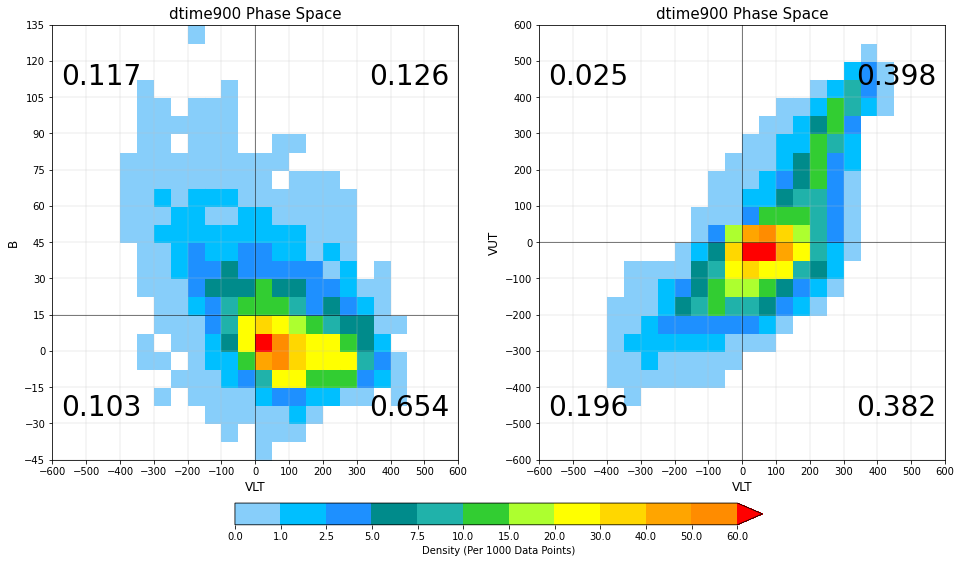

In [19]:
# Plot Cyclone Phase Distribution
def Cyclone_Phase_Dist_Plot(VLT_B, VLT_VUT, VLT_Bins, B_Bins, VUT_Bins, Bounds, Colours, Model):
    Fig = pyplot.figure(figsize=(16,8))
# VLT B Distribution
    Axis = Fig.add_subplot(1,2,1)
    for j in range(len(VLT_B)):
        for k in range(len(VLT_B[0])):
            Colour = Dist_Colour(VLT_B[j][k])
            pyplot.fill_between([VLT_Bins[j],VLT_Bins[j+1]], B_Bins[k], B_Bins[k+1], color=Colour)
    x_Axis = numpy.arange(Bins_Bounds[0],Bins_Bounds[1]+100,100)
    y_Axis = numpy.arange(Bins_Bounds[3],Bins_Bounds[4]+15,15)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(Bins_Bounds[0],Bins_Bounds[1])
    pyplot.ylim(Bins_Bounds[3],Bins_Bounds[4])
    pyplot.plot([-1000,1000], [15,15], 'black', linewidth=0.5)
    pyplot.plot([0,0], [-150,300], 'black', linewidth=0.5)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel('B', fontsize=12)
    pyplot.title(str(Model + ' Phase Space'), fontsize=15)
# Add Quadrant Percent
    Quadrant_Percent = Phase_Space_Quadrant(VLT_B, "B")
    xloc = [0.88,0.12,0.12,0.88]
    yloc = [0.88,0.88,0.12,0.12]
    for q in range(len(Quadrant_Percent)):
        Axis.text(xloc[q], yloc[q], str('%5.3f' % Quadrant_Percent[q]), ha='center', va='center', \
        transform=Axis.transAxes, fontdict={'size':28},color='black')
#
# VLT VUT Distribution
    Axis = Fig.add_subplot(1,2,2)
    for j in range(len(VLT_VUT)):
        for l in range(len(VLT_VUT[0])):
            Colour = Dist_Colour(VLT_VUT[j][l])
            pyplot.fill_between([VLT_Bins[j],VLT_Bins[j+1]], VUT_Bins[l], VUT_Bins[l+1], color=Colour)
    x_Axis = numpy.arange(Bins_Bounds[0],Bins_Bounds[1]+100,100)
    y_Axis = numpy.arange(Bins_Bounds[0],Bins_Bounds[1]+100,100)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(Bins_Bounds[0],Bins_Bounds[1])
    pyplot.ylim(Bins_Bounds[0],Bins_Bounds[1])
    pyplot.plot([-1000,1000], [0,0], 'black', linewidth=0.5)
    pyplot.plot([0,0], [-1000,1000], 'black', linewidth=0.5)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel('VUT', fontsize=12)
    pyplot.title(str(Model + ' Phase Space'), fontsize=15)
# Add Quadrant Percent
    Quadrant_Percent = Phase_Space_Quadrant(VLT_VUT, "VUT")
    for q in range(len(Quadrant_Percent)):
        Axis.text(xloc[q], yloc[q], str('%5.3f' % Quadrant_Percent[q]), ha='center', va='center', \
        transform=Axis.transAxes, fontdict={'size':28},color='black')
#
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("Density (10^-3)", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='max')
    Cax = Axis.inset_axes([-0.75, -0.15, 1.3, 0.05], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, \
    label='Density (Per 1000 Data Points)', ticks=Bounds, shrink=0.7)
    return (Fig)
Fig = Cyclone_Phase_Dist_Plot(Dtime900_VLT_B, Dtime900_VLT_VUT, VLT_Bins, B_Bins, VUT_Bins, Dist_Bounds, Dist_Colours, "dtime900")

In [20]:
# Calculate Difference Between Models
def Cyclone_Phase_Diff(B_1, VUT_1, B_2, VUT_2):
    B_Diff = B_1 - B_2
    VUT_Diff = VUT_1 - VUT_2
    return (B_Diff, VUT_Diff)

In [21]:
# Create Function of Colours of Cyclone Phase Difference Plots
Diff_Colours = ['navy', 'mediumblue', 'dodgerblue', 'deepskyblue', 'turquoise', 'limegreen', 'greenyellow', \
'yellow', 'gold', 'orange', 'darkorange', 'orangered', 'red', 'firebrick']
#Diff_Bounds = numpy.array([-20,-10,-5,-2.5,-1,-0.5,0,0.5,1,2.5,5,10,20])
Diff_Bounds = numpy.array([-30,-20,-15,-10,-5,-2.5,0,2.5,5,10,15,20,30])
def Diff_Colour(Diff):
    for k in range(len(Diff_Colours)):
        if Diff == 0:
            Colour = 'white'
        else:
            if k == 0:
                if Diff < Diff_Bounds[k]:
                    Colour = Diff_Colours[k]
            elif k < len(Diff_Colours)-1:
                if Diff <= Diff_Bounds[k] and Diff > Diff_Bounds[k-1]:
                    Colour = Diff_Colours[k]
            else:
                if Diff > Diff_Bounds[k-1]:
                    Colour = Diff_Colours[k]
    return (Colour)

In [22]:
# Plot Cyclone Phase Distribution Difference Between ERA and REA
def Cyclone_Phase_Diff_Plot(Model_1, Model_2, VLT_B_1, VLT_VUT_1, VLT_B_2, VLT_VUT_2, VLT_Bins, B_Bins, VUT_Bins, \
Diff_Bounds, Diff_Colours):
# Apply Difference Between Models Function
    VLT_B_Diff, VLT_VUT_Diff = Cyclone_Phase_Diff(VLT_B_1, VLT_VUT_1, VLT_B_2, VLT_VUT_2)
    Fig = pyplot.figure(figsize=(16,8))
#
# VLT B Distribution
    Axis = Fig.add_subplot(1,2,1)
    for j in range(len(VLT_B_Diff)):
        for k in range(len(VLT_B_Diff[0])):
            Colour = Diff_Colour(VLT_B_Diff[j][k])
            pyplot.fill_between([VLT_Bins[j],VLT_Bins[j+1]], B_Bins[k], B_Bins[k+1], color=Colour)
    x_Axis = numpy.arange(Bins_Bounds[0],Bins_Bounds[1]+100,100)
    y_Axis = numpy.arange(Bins_Bounds[3],Bins_Bounds[4]+15,15)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(Bins_Bounds[0],Bins_Bounds[1])
    pyplot.ylim(Bins_Bounds[3],Bins_Bounds[4])
    pyplot.plot([-1000,1000], [15,15], 'black', linewidth=0.5)
    pyplot.plot([0,0], [-150,300], 'black', linewidth=0.5)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel('B', fontsize=12)
    pyplot.title(str(Model_1 + ' - ' + Model_2 + ' Difference Phase Space'), fontsize=15)
# Add Quadrant Percent
    Quadrant_Percent = numpy.array(Phase_Space_Quadrant(VLT_B_1, "B")) - numpy.array(Phase_Space_Quadrant(VLT_B_2, "B"))
    xloc = [0.88,0.12,0.12,0.88]
    yloc = [0.88,0.88,0.12,0.12]
    for q in range(len(Quadrant_Percent)):
        Axis.text(xloc[q], yloc[q], str('%5.3f' % Quadrant_Percent[q]), ha='center', va='center', \
        transform=Axis.transAxes, fontdict={'size':28},color='black')
#
# VLT VUT Distribution
    Axis = Fig.add_subplot(1,2,2)
    for j in range(len(VLT_VUT_Diff)):
        for l in range(len(VLT_VUT_Diff[0])):
            Colour = Diff_Colour(VLT_VUT_Diff[j][l])
            pyplot.fill_between([VLT_Bins[j],VLT_Bins[j+1]], VUT_Bins[l], VUT_Bins[l+1], color=Colour)
    x_Axis = numpy.arange(Bins_Bounds[0],Bins_Bounds[1]+100,100)
    y_Axis = numpy.arange(Bins_Bounds[0],Bins_Bounds[1]+100,100)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(Bins_Bounds[0],Bins_Bounds[1])
    pyplot.ylim(Bins_Bounds[0],Bins_Bounds[1])
    pyplot.plot([-1000,1000], [0,0], 'black', linewidth=0.5)
    pyplot.plot([0,0], [-1000,1000], 'black', linewidth=0.5)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    pyplot.xlabel('VLT', fontsize=12)
    pyplot.ylabel('VUT', fontsize=12)
    pyplot.title(str(Model_1 + ' - ' + Model_2 + ' Difference Phase Space'), fontsize=15)
# Add Quadrant Percent
    Quadrant_Percent = numpy.array(Phase_Space_Quadrant(VLT_VUT_1, "VUT")) - numpy.array(Phase_Space_Quadrant(VLT_VUT_2, "VUT"))
    for q in range(len(Quadrant_Percent)):
        Axis.text(xloc[q], yloc[q], str('%5.3f' % Quadrant_Percent[q]), ha='center', va='center', \
        transform=Axis.transAxes, fontdict={'size':28},color='black')
#
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("Density (10^-3)", Diff_Colours, N=len(Diff_Colours))
    Norm = mcolors.BoundaryNorm(Diff_Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([-0.75, -0.15, 1.3, 0.05], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, \
    label='Density Difference (Per 1000 Data Points)', ticks=Diff_Bounds, shrink=0.7)

In [23]:
# Create Lat Lon Bins
def Lat_Lon_Bins(Lat_Min, Lat_Max, Lat_Bin_Width, Lon_Min, Lon_Max, Lon_Bin_Width):
    Lat_Bins = numpy.arange(Lat_Min, Lat_Max+Lat_Bin_Width, Lat_Bin_Width)
    Lon_Bins = numpy.arange(Lon_Min, Lon_Max+Lon_Bin_Width, Lon_Bin_Width)
    return (Lat_Bins, Lon_Bins)
#Lat_Bins, Lon_Bins = Lat_Lon_Bins(0,65,5,-105,15,5)
Lat_Bins, Lon_Bins = Lat_Lon_Bins(0,65,5,-105,15,5)
#print (Lat_Bins)
#print (Lon_Bins)

In [24]:
# Create Function to Calculate Spatial Distribution of B Value
def Spatial_Distribution(DF, Var, Lat_Bins, Lon_Bins):
    Lat_Lon_Count = numpy.zeros((len(Lat_Bins)-1, len(Lon_Bins)-1))
    Lat_Lon_Values_Median = numpy.zeros((len(Lat_Bins)-1, len(Lon_Bins)-1))
    Lat_Lon_Values_Lists = []
    for j in range(len(Lat_Bins)-1):
        Lat_Lon_Values_Lists.append([])
        for k in range(len(Lon_Bins)-1):
            Lat_Lon_Values_Lists[j].append([])
            
#    Length = len(DF["VLT"])
#    VLT_Width = numpy.zeros(len(VLT_Bins)-1)
#    B_Width = numpy.zeros(len(B_Bins)-1)
#    VUT_Width = numpy.zeros(len(VUT_Bins)-1)
#    VLT_B_Density = numpy.zeros((len(VLT_B_Count), len(VLT_B_Count[0])))
#    VLT_VUT_Density = numpy.zeros((len(VLT_VUT_Count), len(VLT_VUT_Count[0])))
#
# Create Boundaries For Values to Ignore NaN and Ignore WeakStorms With SLP > 1010hPa
    if Var == "VLT" or Var == "VUT":
        Value_Bounds = numpy.array([Bins_Bounds[0],Bins_Bounds[1]])
    if Var == "B":
        Value_Bounds = numpy.array([Bins_Bounds[3],Bins_Bounds[4]])
    SLP_Bounds = 1010
#
# Count Lat Lon Distribution and List of Values in Each Gridbox
    for i in range(len(DF[Var])):
        if DF["SLP(hPa)"][i] <= SLP_Bounds:
            if DF[Var][i] >= Value_Bounds[0] and DF[Var][i] <= Value_Bounds[1]:
                for j in range(len(Lat_Bins)-1):
                    if DF["Lat"][i] > Lat_Bins[j] and DF["Lat"][i] <= Lat_Bins[j+1]:
                        for k in range(len(Lon_Bins)-1):
                            if DF["Lon"][i] > Lon_Bins[k] and DF["Lon"][i] <= Lon_Bins[k+1]:
                                Lat_Lon_Count[j][k] += 1
                                Lat_Lon_Values_Lists[j][k].append(DF[Var][i])
#
# Calculate Median Value in Each Gridbox
    for j in range(len(Lat_Lon_Count)):
        for k in range(len(Lat_Lon_Count[j])):
# Ignore Gridboxes with <= 10 Values
            if Lat_Lon_Count[j][k] > 10:
                Lat_Lon_Values_Median[j][k] = numpy.median(Lat_Lon_Values_Lists[j][k])
    return (Lat_Lon_Count, Lat_Lon_Values_Median)
Dtime900_Spatial_Count, Dtime900_Spatial_B = Spatial_Distribution(Dtime900_DF, "B", Lat_Bins, Lon_Bins)

In [25]:
Dtime900_Spatial_B

array([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.7000e-01,  0.0000e+00,  1.5700e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  5.9000e-01,  0.0000e+00, -7.0000e-02,
         8.9000e-01,  8.1500e-01,  0.0000e+00,  0.0000e+00,  3.2950e+00,
         1.2600e+00,  2.9050e+00,  5.9000e-01,  4.2600e+00,  3.8000e+00,
         4.5500e+00,  5.2400e+00,  9.7700e+00,  4.9800e+00,  0.0000e+00,
  

In [26]:
# Create Function For Spatial Distribution Count Colours
Spatial_Count_Colours = ['lightskyblue', 'deepskyblue', 'dodgerblue', 'darkcyan', 'lightseagreen', \
'limegreen', 'greenyellow', 'yellow', 'gold', 'orange', 'darkorange', 'red']
Spatial_Count_Bounds = numpy.array([0,2,5,10,20,30,40,50,75,100,125,150])
#Spatial_Count_Bounds = numpy.array([0,1,3,5,10,15,20,25,30,40,50,60])
#
def Spatial_Count_Colour(Density):
    for k in range(len(Spatial_Count_Colours)):
        if Density == 0:
            Colour = 'white'
        else:
            if k != len(Spatial_Count_Colours)-1:
                if Density <= Spatial_Count_Bounds[k+1] and Density > Spatial_Count_Bounds[k]:
                    Colour = Spatial_Count_Colours[k]
            else:
                if Density > Spatial_Count_Bounds[k]:
                    Colour = Spatial_Count_Colours[k]
    return (Colour)

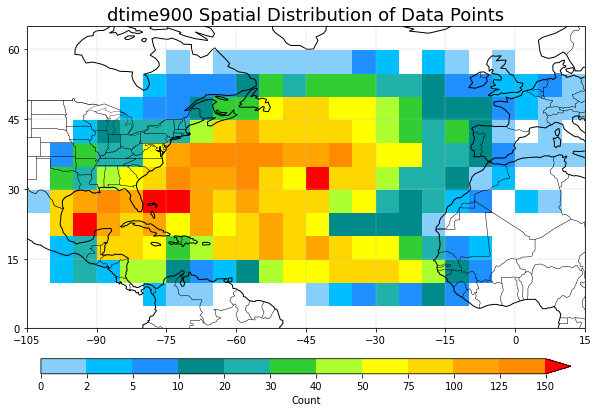

In [27]:
# Plot Spatial Distribution Count of Data Points
def Spatial_Count_Plot(Spatial_Count, Lat_Bins, Lon_Bins, Bounds, Colours, Model):
    Fig = pyplot.figure(figsize=(10,10))
    Axis = Fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
#
# Add Coastlines
    Axis.coastlines()
    Axis.add_feature(cfeature.BORDERS, linewidth=0.5)
    Axis.add_feature(cfeature.STATES, linewidth=0.3)
# 
# Plot Data
    for j in range(len(Spatial_Count)):
        for k in range(len(Spatial_Count[0])):
            Colour = Spatial_Count_Colour(Spatial_Count[j][k])
#            print ([Lon_Bins[k],Lon_Bins[k+1]], Lat_Bins[j], Lat_Bins[j+1], Colour)
            pyplot.fill_between([Lon_Bins[k],Lon_Bins[k+1]], Lat_Bins[j], Lat_Bins[j+1], color=Colour)
    x_Axis = numpy.arange(-105,30,15)
    y_Axis = numpy.arange(0,75,15)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(-105,15)
    pyplot.ylim(0,65)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
#    pyplot.xlabel('VLT', fontsize=12)
#    pyplot.ylabel('VUT', fontsize=12)
    pyplot.title(str(Model + ' Spatial Distribution of Data Points'), fontsize=18)
#
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("Count", Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='max')
    Cax = Axis.inset_axes([0.025, -0.15, 0.95, 0.05], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, \
    label='Count', ticks=Bounds, shrink=0.7)
    return (Fig)
Fig = Spatial_Count_Plot(Dtime900_Spatial_Count, Lat_Bins, Lon_Bins, Spatial_Count_Bounds, Spatial_Count_Colours, "dtime900")

In [28]:
# Create Function For B Value Colours
B_Colours = ['red', 'orangered', 'darkorange', 'orange', 'gold', 'yellow', 'greenyellow', 'limegreen', 'turquoise', 'deepskyblue', 'dodgerblue', 'mediumblue', 'navy']
#B_Bounds = numpy.arange(-15,75,5)
B_Bounds = numpy.array([-10,-5,0,5,10,15,20,25,30,40,50,60])
#print (len(B_Colours))
#print (len(B_Bounds))
#
def B_Colour(Density):
    for k in range(len(B_Colours)):
        if Density == 0:
            Colour = 'white'
        else:
            if k == 0:
                if Density <= B_Bounds[k]:
                    Colour = B_Colours[k]
            if k != len(B_Colours)-1:
                if Density <= B_Bounds[k] and Density > B_Bounds[k-1]:
                    Colour = B_Colours[k]
            else:
                if Density > B_Bounds[k-1]:
                    Colour = B_Colours[k]
    return (Colour)

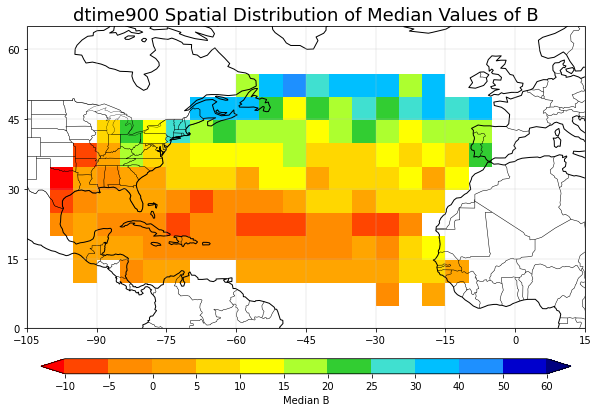

In [29]:
# Plot Spatial Distribution of B Values
def Spatial_B_Plot(Spatial_B, Lat_Bins, Lon_Bins, Bounds, Colours, Var, Model):
    Fig = pyplot.figure(figsize=(10,10))
    Axis = Fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
#
# Add Coastlines
    Axis.coastlines()
    Axis.add_feature(cfeature.BORDERS, linewidth=0.5)
    Axis.add_feature(cfeature.STATES, linewidth=0.3)
# 
# Plot Data
    for j in range(len(Spatial_B)):
        for k in range(len(Spatial_B[0])):
            Colour = B_Colour(Spatial_B[j][k])
#            print ([Lon_Bins[k],Lon_Bins[k+1]], Lat_Bins[j], Lat_Bins[j+1], Colour)
            pyplot.fill_between([Lon_Bins[k],Lon_Bins[k+1]], Lat_Bins[j], Lat_Bins[j+1], color=Colour)
    x_Axis = numpy.arange(-105,30,15)
    y_Axis = numpy.arange(0,75,15)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(-105,15)
    pyplot.ylim(0,65)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
#    pyplot.xlabel('VLT', fontsize=12)
#    pyplot.ylabel('VUT', fontsize=12)
    pyplot.title(str(Model + ' Spatial Distribution of Median Values of ' + Var), fontsize=18)
#
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list(str("Median " + Var), Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([0.025, -0.15, 0.95, 0.05], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, \
    label=str("Median " + Var), ticks=Bounds, shrink=0.7)
    return (Fig)
Fig = Spatial_B_Plot(Dtime900_Spatial_B, Lat_Bins, Lon_Bins, B_Bounds, B_Colours, "B", "dtime900")

In [30]:
# Calculate Spatial Distribution of VLT
Dtime900_Spatial_Count, Dtime900_Spatial_VLT = Spatial_Distribution(Dtime900_DF, "VLT", Lat_Bins, Lon_Bins)
#print (Dtime900_Spatial_VLT)

In [31]:
# Create Function For VLT and VUT Value Colours
#VLT_Bounds = numpy.array([-250,-200,-150,-100,-50,0,50,100,150,200,250])
VLT_Bounds = numpy.array([-200,-150,-100,-50,0,50,100,150,200])
VLT_Colours = ['mediumblue', 'dodgerblue', 'deepskyblue', 'limegreen', 'greenyellow', 'yellow', 'gold', 'orange', 'darkorange', 'red']
#print (len(VLT_Colours))
#print (len(VLT_Bounds))
#
def VLT_Colour(Density):
    for k in range(len(VLT_Colours)):
        if Density == 0:
            Colour = 'white'
        else:
            if k == 0:
                if Density <= VLT_Bounds[k]:
                    Colour = VLT_Colours[k]
            if k != len(VLT_Colours)-1:
                if Density <= VLT_Bounds[k] and Density > VLT_Bounds[k-1]:
                    Colour = VLT_Colours[k]
            else:
                if Density > VLT_Bounds[k-1]:
                    Colour = VLT_Colours[k]
    return (Colour)

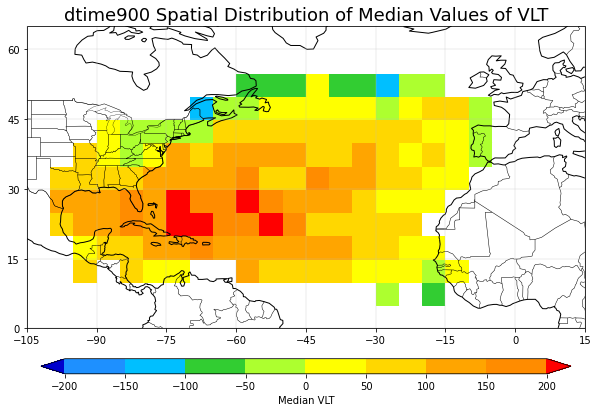

In [32]:
# Plot Spatial Distribution of VLT Values
def Spatial_VT_Plot(Spatial_VLT, Lat_Bins, Lon_Bins, Bounds, Colours, Var, Model):
    Fig = pyplot.figure(figsize=(10,10))
    Axis = Fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
#
# Add Coastlines
    Axis.coastlines()
    Axis.add_feature(cfeature.BORDERS, linewidth=0.5)
    Axis.add_feature(cfeature.STATES, linewidth=0.3)
# 
# Plot Data
    for j in range(len(Spatial_VLT)):
        for k in range(len(Spatial_VLT[0])):
            Colour = VLT_Colour(Spatial_VLT[j][k])
#            print ([Lon_Bins[k],Lon_Bins[k+1]], Lat_Bins[j], Lat_Bins[j+1], Colour)
            pyplot.fill_between([Lon_Bins[k],Lon_Bins[k+1]], Lat_Bins[j], Lat_Bins[j+1], color=Colour)
    x_Axis = numpy.arange(-105,30,15)
    y_Axis = numpy.arange(0,75,15)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(-105,15)
    pyplot.ylim(0,65)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
#    pyplot.xlabel('VLT', fontsize=12)
#    pyplot.ylabel('VUT', fontsize=12)
    pyplot.title(str(Model + ' Spatial Distribution of Median Values of ' + Var), fontsize=18)
#
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list(str("Median " + Var), Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([0.025, -0.15, 0.95, 0.05], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, \
    label=str("Median " + Var), ticks=Bounds, shrink=0.7)
    return (Fig)
Fig = Spatial_VT_Plot(Dtime900_Spatial_VLT, Lat_Bins, Lon_Bins, VLT_Bounds, VLT_Colours, "VLT", "dtime900")

In [33]:
# Calculate Spatial Distribution of VUT
Dtime900_Spatial_Count, Dtime900_Spatial_VUT = Spatial_Distribution(Dtime900_DF, "VUT", Lat_Bins, Lon_Bins)
#print (Dtime900_Spatial_VUT)

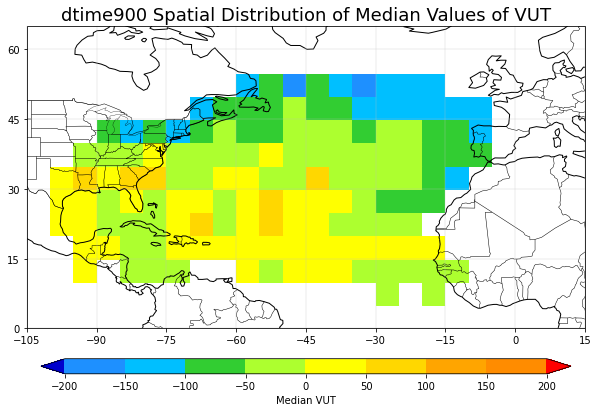

In [34]:
# Plot Spatial Distribution of VUT Values
Fig = Spatial_VT_Plot(Dtime900_Spatial_VUT, Lat_Bins, Lon_Bins, VLT_Bounds, VLT_Colours, "VUT", "dtime900")

In [35]:
# Open File
Dtime1800_DF_Init, Dtime1800_Storm_List = Create_DF(Diri + 'traj_et_dtime1800_avg')
#Dtime1800_DF_Init

In [36]:
Dtime1800_DF = Cyclone_Type(Dtime1800_DF_Init, Dtime1800_Storm_List)

In [37]:
#Dtime1800_DF[Dtime1800_DF['SLP(hPa)'] <= 910]

In [38]:
#Plot_Cyclone_Track('0019', Dtime1800_DF, SLP_Bounds, SLP_Colours, 4)

In [39]:
#Plot_Cyclone_SLP('0236', Dtime900_DF, SLP_Bounds, SLP_Colours, 3)

In [40]:
#Plot_Cyclone_Winds('0236', Dtime900_DF, SLP_Bounds, SLP_Colours, 2)

In [41]:
#Plot_Cyclone_Phase('0019', Dtime1800_DF, SLP_Bounds, SLP_Colours, 3)

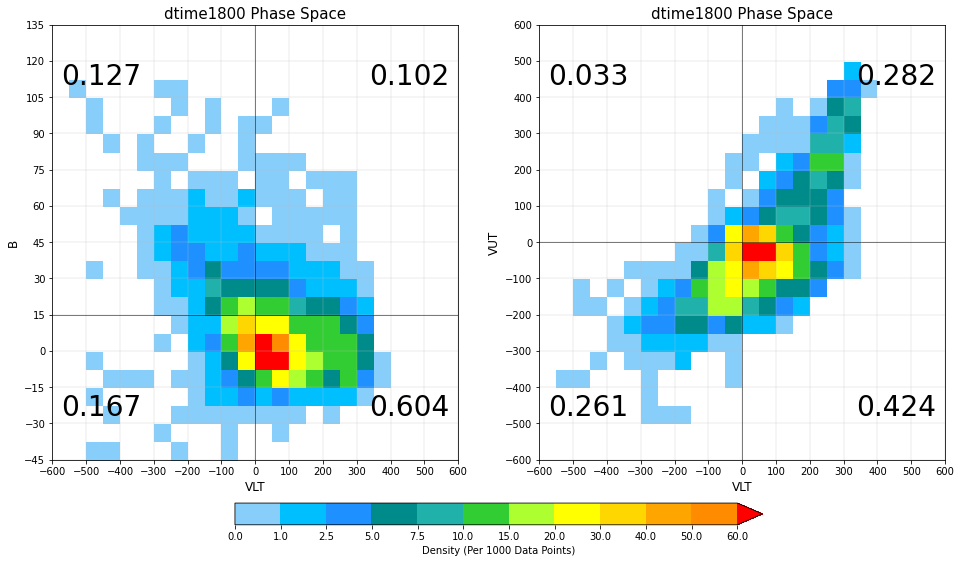

In [42]:
Dtime1800_VLT_B, Dtime1800_VLT_VUT = Phase_Space_Distribution(Dtime1800_DF, VLT_Bins, B_Bins, VUT_Bins)
Fig = Cyclone_Phase_Dist_Plot(Dtime1800_VLT_B, Dtime1800_VLT_VUT, VLT_Bins, B_Bins, VUT_Bins, Dist_Bounds, Dist_Colours, "dtime1800")

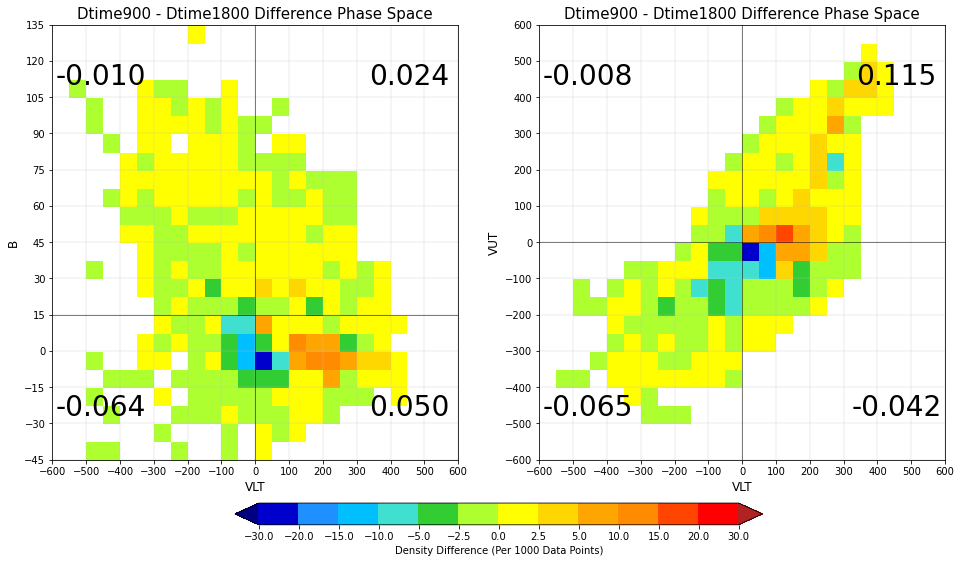

In [43]:
Cyclone_Phase_Diff_Plot("Dtime900", "Dtime1800", Dtime900_VLT_B, Dtime900_VLT_VUT, Dtime1800_VLT_B, Dtime1800_VLT_VUT, \
VLT_Bins, B_Bins, VUT_Bins, Diff_Bounds, Diff_Colours)

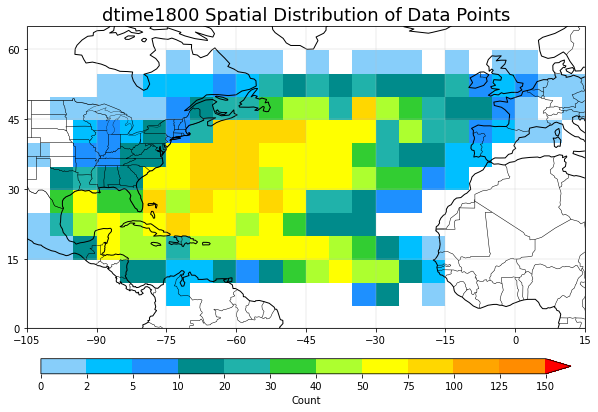

In [44]:
Dtime1800_Spatial_Count, Dtime1800_Spatial_B = Spatial_Distribution(Dtime1800_DF, "B", Lat_Bins, Lon_Bins)
Fig = Spatial_Count_Plot(Dtime1800_Spatial_Count, Lat_Bins, Lon_Bins, Spatial_Count_Bounds, Spatial_Count_Colours, "dtime1800")

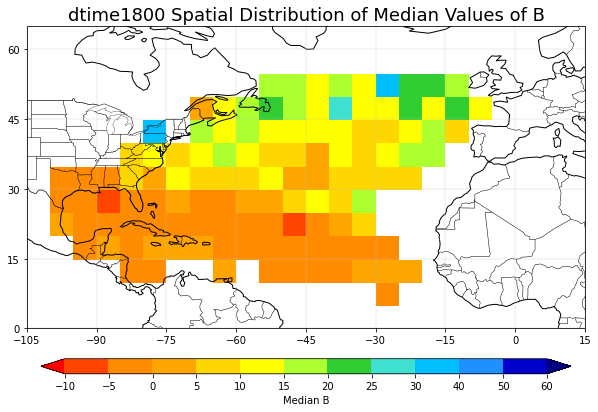

In [45]:
Fig = Spatial_B_Plot(Dtime1800_Spatial_B, Lat_Bins, Lon_Bins, B_Bounds, B_Colours, "B", "dtime1800")

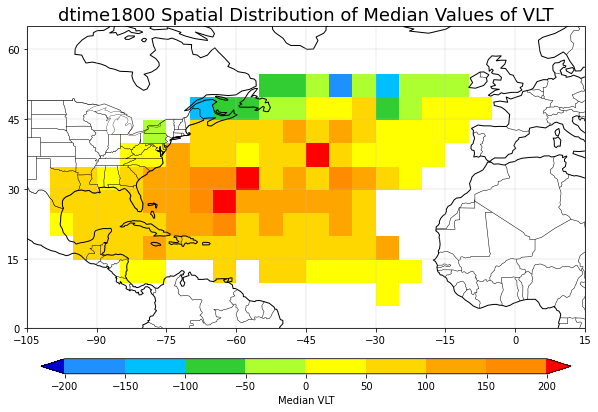

In [46]:
Dtime1800_Spatial_Count, Dtime1800_Spatial_VLT = Spatial_Distribution(Dtime1800_DF, "VLT", Lat_Bins, Lon_Bins)
Fig = Spatial_VT_Plot(Dtime1800_Spatial_VLT, Lat_Bins, Lon_Bins, VLT_Bounds, VLT_Colours, "VLT", "dtime1800")

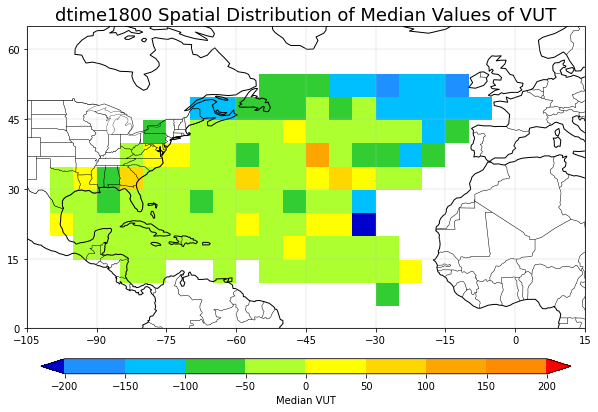

In [47]:
Dtime1800_Spatial_Count, Dtime1800_Spatial_VUT = Spatial_Distribution(Dtime1800_DF, "VUT", Lat_Bins, Lon_Bins)
Fig = Spatial_VT_Plot(Dtime1800_Spatial_VUT, Lat_Bins, Lon_Bins, VLT_Bounds, VLT_Colours, "VUT", "dtime1800")

In [48]:
# Open File
Dtime450_DF_Init, Dtime450_Storm_List = Create_DF(Diri + 'traj_et_tau3600_avg')
#Dtime450_DF_Init

In [49]:
Dtime450_DF = Cyclone_Type(Dtime450_DF_Init, Dtime450_Storm_List)

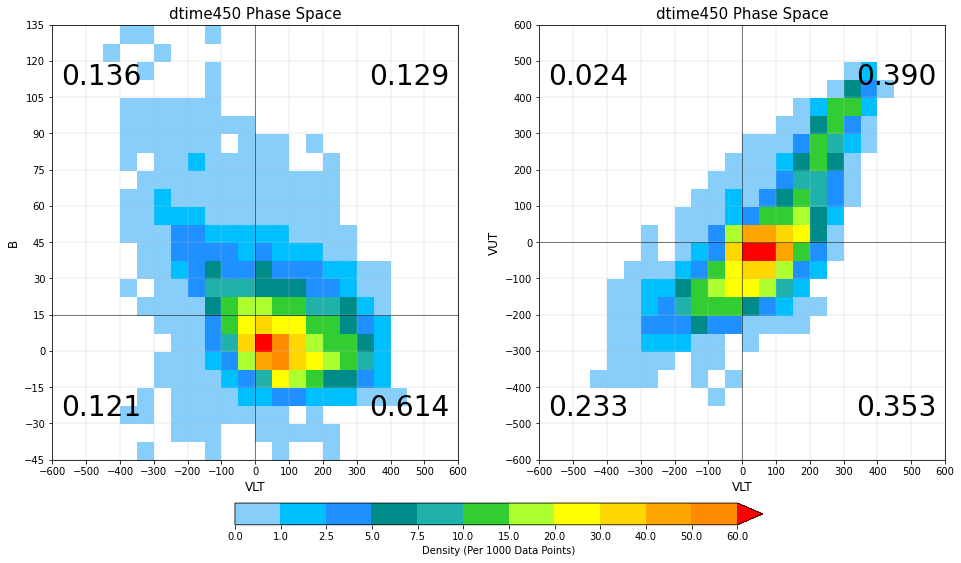

In [50]:
Dtime450_VLT_B, Dtime450_VLT_VUT = Phase_Space_Distribution(Dtime450_DF, VLT_Bins, B_Bins, VUT_Bins)
Fig = Cyclone_Phase_Dist_Plot(Dtime450_VLT_B, Dtime450_VLT_VUT, VLT_Bins, B_Bins, VUT_Bins, Dist_Bounds, Dist_Colours, "dtime450")

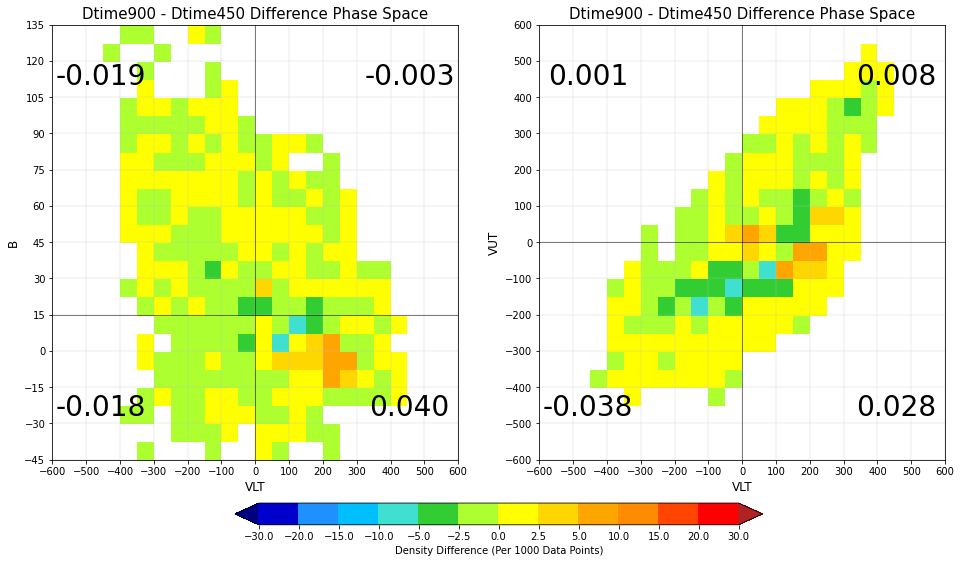

In [51]:
Cyclone_Phase_Diff_Plot("Dtime900", "Dtime450", Dtime900_VLT_B, Dtime900_VLT_VUT, Dtime450_VLT_B, Dtime450_VLT_VUT, \
VLT_Bins, B_Bins, VUT_Bins, Diff_Bounds, Diff_Colours)

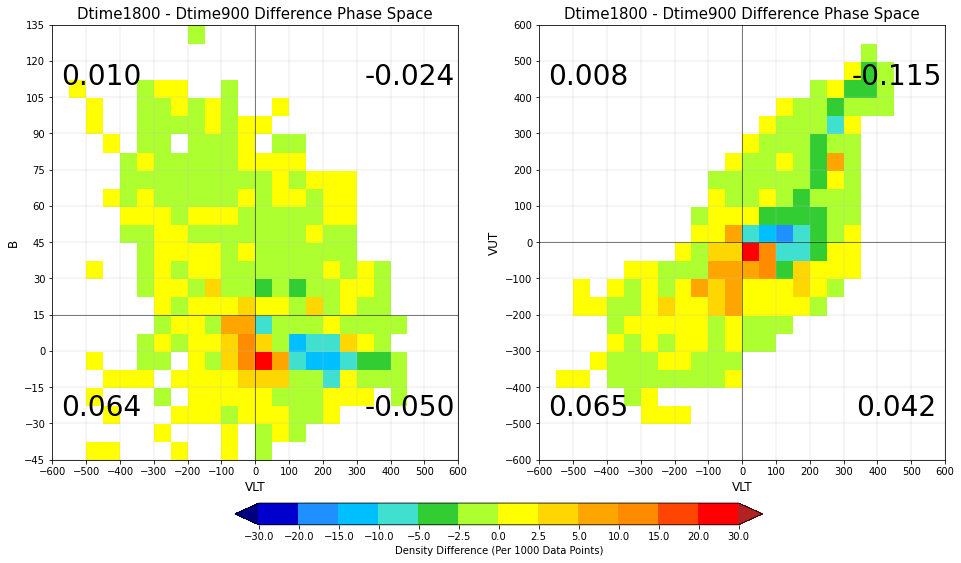

In [52]:
Cyclone_Phase_Diff_Plot("Dtime1800", "Dtime900", Dtime1800_VLT_B, Dtime1800_VLT_VUT, Dtime900_VLT_B, Dtime900_VLT_VUT, \
VLT_Bins, B_Bins, VUT_Bins, Diff_Bounds, Diff_Colours)

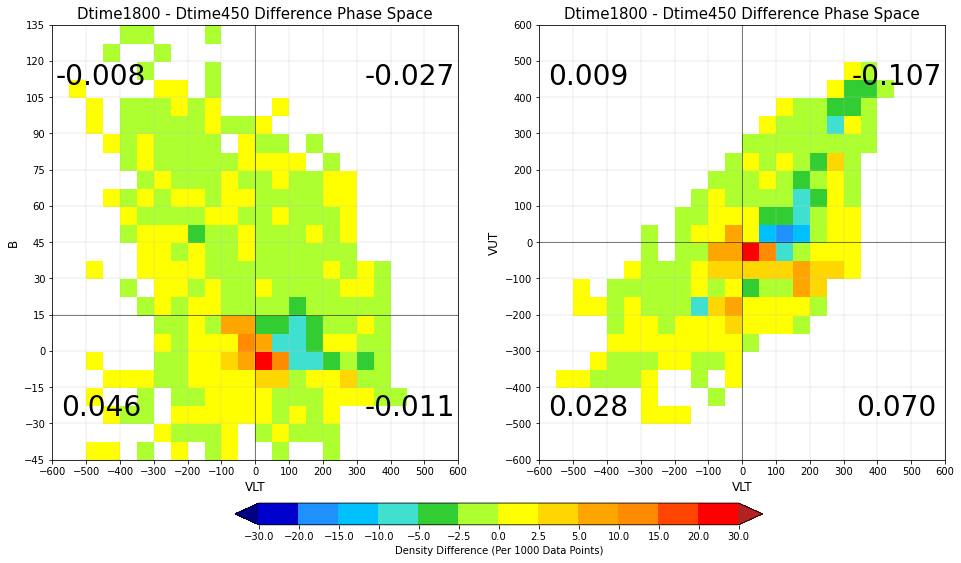

In [53]:
Cyclone_Phase_Diff_Plot("Dtime1800", "Dtime450", Dtime1800_VLT_B, Dtime1800_VLT_VUT, Dtime450_VLT_B, Dtime450_VLT_VUT, \
VLT_Bins, B_Bins, VUT_Bins, Diff_Bounds, Diff_Colours)

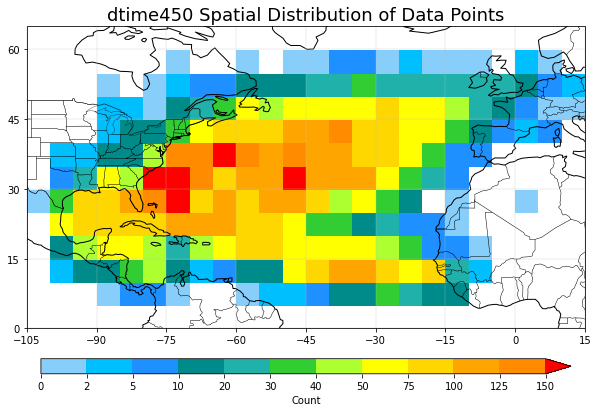

In [54]:
Dtime450_Spatial_Count, Dtime450_Spatial_B = Spatial_Distribution(Dtime450_DF, "B", Lat_Bins, Lon_Bins)
Fig = Spatial_Count_Plot(Dtime450_Spatial_Count, Lat_Bins, Lon_Bins, Spatial_Count_Bounds, Spatial_Count_Colours, "dtime450")

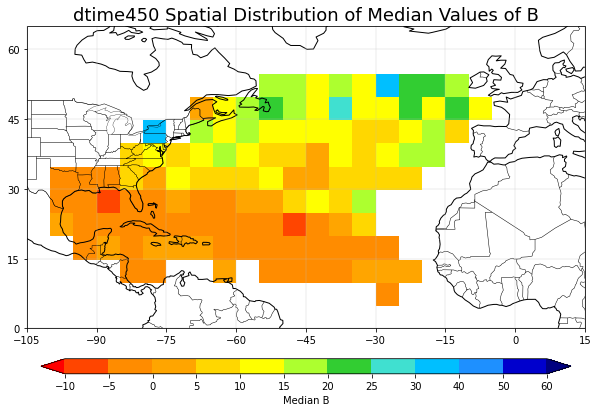

In [55]:
Fig = Spatial_B_Plot(Dtime1800_Spatial_B, Lat_Bins, Lon_Bins, B_Bounds, B_Colours, "B", "dtime450")

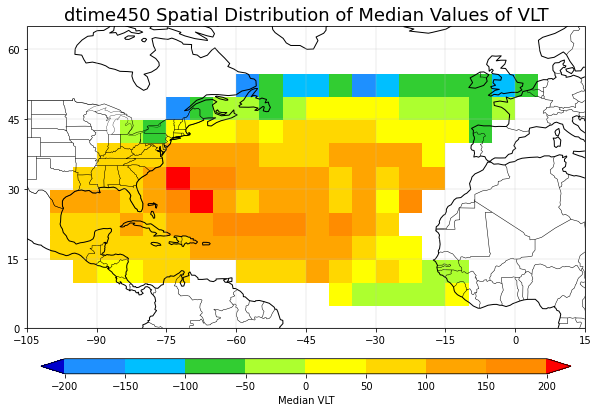

In [56]:
Dtime450_Spatial_Count, Dtime450_Spatial_VLT = Spatial_Distribution(Dtime450_DF, "VLT", Lat_Bins, Lon_Bins)
Fig = Spatial_VT_Plot(Dtime450_Spatial_VLT, Lat_Bins, Lon_Bins, VLT_Bounds, VLT_Colours, "VLT", "dtime450")

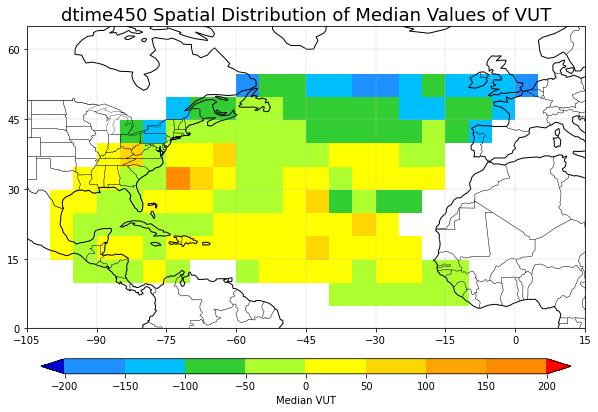

In [57]:
Dtime450_Spatial_Count, Dtime450_Spatial_VUT = Spatial_Distribution(Dtime450_DF, "VUT", Lat_Bins, Lon_Bins)
Fig = Spatial_VT_Plot(Dtime450_Spatial_VUT, Lat_Bins, Lon_Bins, VLT_Bounds, VLT_Colours, "VUT", "dtime450")

In [58]:
# Create Function to Calculate Median Transition Latitude
def Trans_Lat_Find(DF, Var):
    DF = DF[DF[Var] > -728]
    Trans_Lat = 0
# Test Each Latitude Range Until We Find Latitude Where Over 50% Points Above/Below Transition Value
    for l in range(45):
        Test_Lat = l+15
# Create DF For Each 2 Degree Latitude Range
        Test_DF = DF[(DF["Lat"] >= Test_Lat-1) & (DF["Lat"] < Test_Lat+1)]
        if Var == "B":
            Percent = len(Test_DF[Test_DF[Var] > 15]) / len(Test_DF)
#            print (Test_Lat, Percent)
# First Time Percentage Reach Above 50%
            if Percent >= 0.5 and Trans_Lat == 0:
                Trans_Lat = Test_Lat
        else:
            Percent = len(Test_DF[Test_DF[Var] < 0]) / len(Test_DF)
#            print (Test_Lat, Percent)
            if Percent >= 0.5 and Trans_Lat == 0:
                Trans_Lat = Test_Lat
    return (Trans_Lat)

In [80]:
# Find Median Transition Latitude
Trans_Lats = numpy.zeros((3,3))
Trans_Lats[0][0] = Trans_Lat_Find(Dtime450_DF, "B")
Trans_Lats[1][0] = Trans_Lat_Find(Dtime450_DF, "VLT")
Trans_Lats[2][0] = Trans_Lat_Find(Dtime450_DF, "VUT")
Trans_Lats[0][1] = Trans_Lat_Find(Dtime900_DF, "B")
Trans_Lats[1][1] = Trans_Lat_Find(Dtime900_DF, "VLT")
Trans_Lats[2][1] = Trans_Lat_Find(Dtime900_DF, "VUT")
Trans_Lats[0][2] = Trans_Lat_Find(Dtime1800_DF, "B")
Trans_Lats[1][2] = Trans_Lat_Find(Dtime1800_DF, "VLT")
Trans_Lats[2][2] = Trans_Lat_Find(Dtime1800_DF, "VUT")
print (Trans_Lats)

[[43. 42. 46.]
 [45. 47. 46.]
 [21. 25. 15.]]


In [60]:
# Plot Spatial Distribution of B Values
def Spatial_B_Plot(Spatial_B, Lat_Bins, Lon_Bins, Bounds, Colours, Var, Model, Trans_Lat):
    Fig = pyplot.figure(figsize=(10,10))
    Axis = Fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
#
# Add Coastlines
    Axis.coastlines()
    Axis.add_feature(cfeature.BORDERS, linewidth=0.5)
    Axis.add_feature(cfeature.STATES, linewidth=0.3)
# 
# Plot Data
    for j in range(len(Spatial_B)):
        for k in range(len(Spatial_B[0])):
            Colour = B_Colour(Spatial_B[j][k])
#            print ([Lon_Bins[k],Lon_Bins[k+1]], Lat_Bins[j], Lat_Bins[j+1], Colour)
            pyplot.fill_between([Lon_Bins[k],Lon_Bins[k+1]], Lat_Bins[j], Lat_Bins[j+1], color=Colour)
# Plot Transition Latitude
    pyplot.plot([-105,30], [Trans_Lat, Trans_Lat], color='black', linestyle='--', linewidth=2.8)
    x_Axis = numpy.arange(-105,30,15)
    y_Axis = numpy.arange(0,75,15)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(-105,15)
    pyplot.ylim(0,65)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
#    pyplot.xlabel('VLT', fontsize=12)
#    pyplot.ylabel('VUT', fontsize=12)
    pyplot.title(str(Model + ' Spatial Distribution of Median Values of ' + Var), fontsize=18)
#
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list(str("Median " + Var), Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([0.025, -0.15, 0.95, 0.05], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, \
    label=str("Median " + Var), ticks=Bounds, shrink=0.7)
    return (Fig)

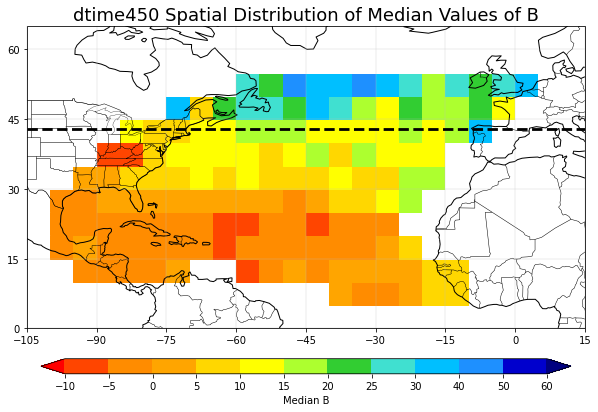

In [61]:
Fig = Spatial_B_Plot(Dtime450_Spatial_B, Lat_Bins, Lon_Bins, B_Bounds, B_Colours, "B", "dtime450", Trans_Lats[0][0])

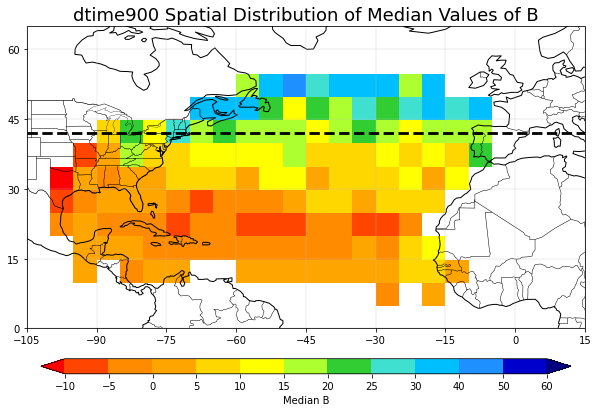

In [62]:
Fig = Spatial_B_Plot(Dtime900_Spatial_B, Lat_Bins, Lon_Bins, B_Bounds, B_Colours, "B", "dtime900", Trans_Lats[0][1])

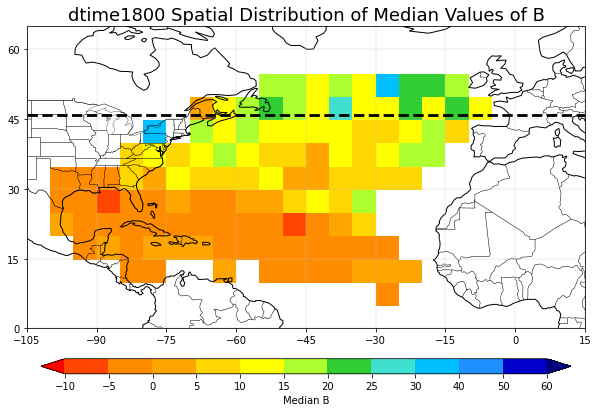

In [63]:
Fig = Spatial_B_Plot(Dtime1800_Spatial_B, Lat_Bins, Lon_Bins, B_Bounds, B_Colours, "B", "dtime1800", Trans_Lats[0][2])

In [64]:
# Plot Spatial Distribution of VLT Values
def Spatial_VT_Plot(Spatial_VLT, Lat_Bins, Lon_Bins, Bounds, Colours, Var, Model, Trans_Lat):
    Fig = pyplot.figure(figsize=(10,10))
    Axis = Fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
#
# Add Coastlines
    Axis.coastlines()
    Axis.add_feature(cfeature.BORDERS, linewidth=0.5)
    Axis.add_feature(cfeature.STATES, linewidth=0.3)
# 
# Plot Data
    for j in range(len(Spatial_VLT)):
        for k in range(len(Spatial_VLT[0])):
            Colour = VLT_Colour(Spatial_VLT[j][k])
#            print ([Lon_Bins[k],Lon_Bins[k+1]], Lat_Bins[j], Lat_Bins[j+1], Colour)
            pyplot.fill_between([Lon_Bins[k],Lon_Bins[k+1]], Lat_Bins[j], Lat_Bins[j+1], color=Colour)
# Plot Transition Latitude
    pyplot.plot([-105,30], [Trans_Lat, Trans_Lat], color='black', linestyle='--', linewidth=2.8)
    x_Axis = numpy.arange(-105,30,15)
    y_Axis = numpy.arange(0,75,15)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(-105,15)
    pyplot.ylim(0,65)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
#    pyplot.xlabel('VLT', fontsize=12)
#    pyplot.ylabel('VUT', fontsize=12)
    pyplot.title(str(Model + ' Spatial Distribution of Median Values of ' + Var), fontsize=18)
#
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list(str("Average " + Var), Colours, N=len(Colours))
    Norm = mcolors.BoundaryNorm(Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([0.025, -0.15, 0.95, 0.05], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, \
    label=str("Average " + Var), ticks=Bounds, shrink=0.7)
    return (Fig)

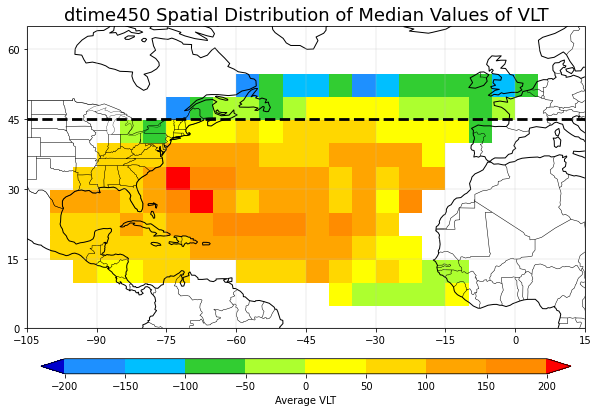

In [65]:
Fig = Spatial_VT_Plot(Dtime450_Spatial_VLT, Lat_Bins, Lon_Bins, VLT_Bounds, VLT_Colours, "VLT", "dtime450", Trans_Lats[1][0])

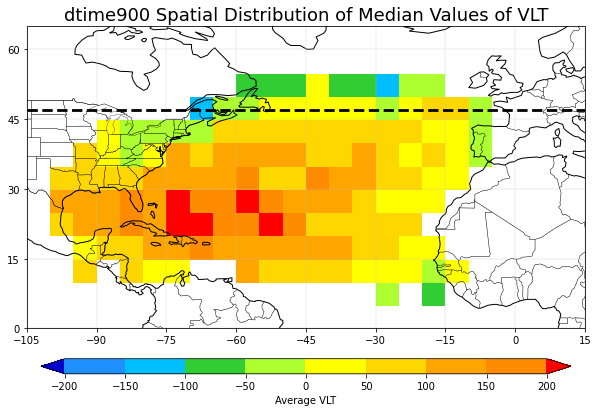

In [66]:
Fig = Spatial_VT_Plot(Dtime900_Spatial_VLT, Lat_Bins, Lon_Bins, VLT_Bounds, VLT_Colours, "VLT", "dtime900", Trans_Lats[1][1])

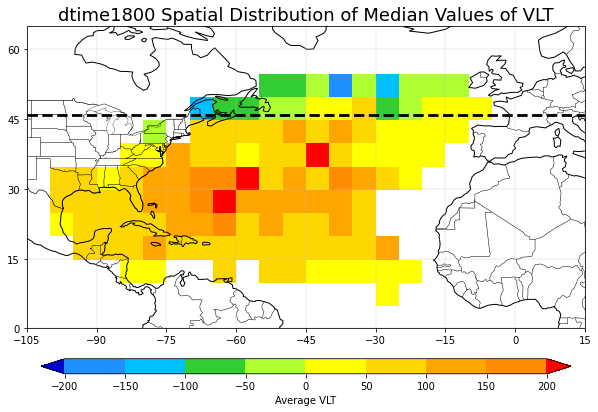

In [67]:
Fig = Spatial_VT_Plot(Dtime1800_Spatial_VLT, Lat_Bins, Lon_Bins, VLT_Bounds, VLT_Colours, "VLT", "dtime1800", Trans_Lats[1][2])

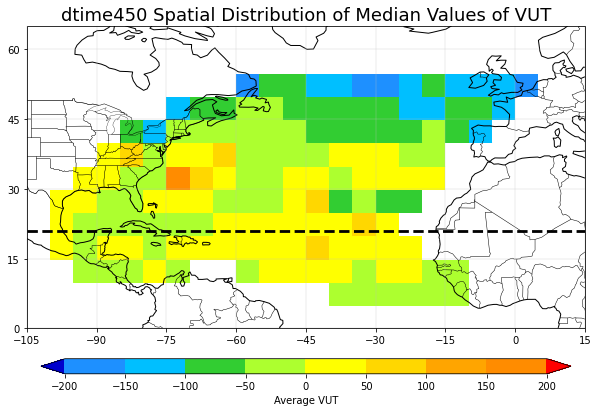

In [83]:
Fig = Spatial_VT_Plot(Dtime450_Spatial_VUT, Lat_Bins, Lon_Bins, VLT_Bounds, VLT_Colours, "VUT", "dtime450", Trans_Lats[2][0])

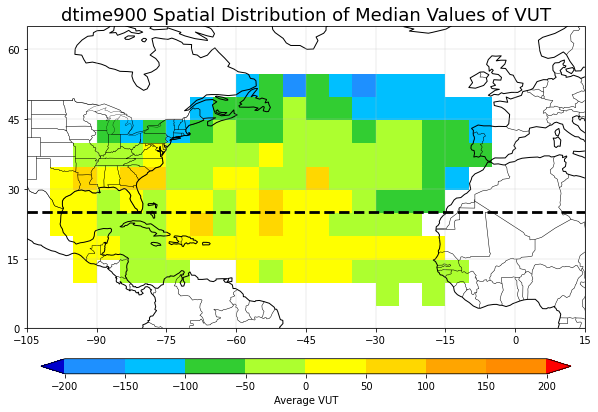

In [86]:
Fig = Spatial_VT_Plot(Dtime900_Spatial_VUT, Lat_Bins, Lon_Bins, VLT_Bounds, VLT_Colours, "VUT", "dtime900", Trans_Lats[2][1])

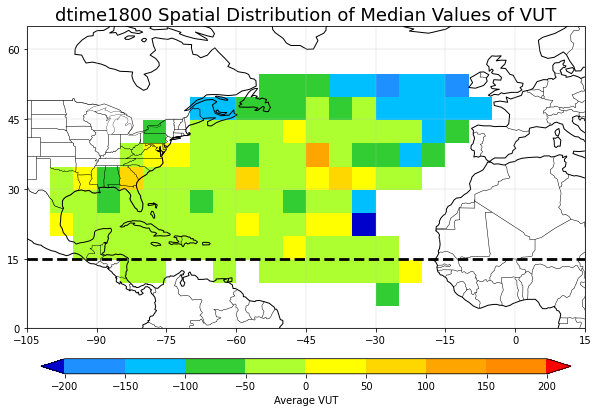

In [87]:
Fig = Spatial_VT_Plot(Dtime1800_Spatial_VUT, Lat_Bins, Lon_Bins, VLT_Bounds, VLT_Colours, "VUT", "dtime1800", Trans_Lats[2][2])

In [68]:
# Calculate Difference Between Models
def Spatial_Diff(Val_1, Val_2):
    if Val_1 != 0 and Val_2 != 0:
        Diff = Val_1 - Val_2
    else:
        Diff = 0
    return (Diff)

In [69]:
# Create Function of Colours of Spatial Distribution Difference Plots
B_Diff_Colours = ['red', 'orangered', 'darkorange', 'orange', \
'cyan', 'deepskyblue', 'mediumblue', 'navy']
VT_Diff_Colours = ['navy', 'mediumblue', 'deepskyblue', 'cyan', \
'orange', 'darkorange', 'orangered', 'red']
B_Diff_Bounds = numpy.array([-20,-10,-5,0,5,10,20])
VT_Diff_Bounds = numpy.array([-100,-50,-20,0,20,50,100])
def Spatial_Diff_Colour(Diff, Diff_Colours, Diff_Bounds):
    for k in range(len(Diff_Colours)):
        if Diff == 0:
            Colour = 'white'
        else:
            if k == 0:
                if Diff < Diff_Bounds[k]:
                    Colour = Diff_Colours[k]
            elif k < len(Diff_Colours)-1:
                if Diff <= Diff_Bounds[k] and Diff > Diff_Bounds[k-1]:
                    Colour = Diff_Colours[k]
            else:
                if Diff > Diff_Bounds[k-1]:
                    Colour = Diff_Colours[k]
    return (Colour)

In [70]:
# Plot Spatial Distribution Differences
def Spatial_Diff_Plot(Model_1, Model_2, B_1, B_2, VLT_1, VLT_2, VUT_1, VUT_2, Lon_Bins, Lat_Bins, \
Diff_Bounds, Diff_Colours):
# Apply Difference Between Models Function
    B_Diff = numpy.zeros((len(B_1),len(B_1[0])))
    VLT_Diff = numpy.zeros((len(VLT_1),len(VUT_1[0])))
    VUT_Diff = numpy.zeros((len(VUT_1),len(VUT_1[0])))
    for j in range(len(B_1)):
        for k in range(len(B_1[0])):
            B_Diff[j][k] = Spatial_Diff(B_1[j][k], B_2[j][k])
            VLT_Diff[j][k] = Spatial_Diff(VLT_1[j][k], VLT_2[j][k])
            VUT_Diff[j][k] = Spatial_Diff(VUT_1[j][k], VUT_2[j][k])
#
# Add Coastlines
    Fig = pyplot.figure(figsize=(12,12))
    Axis = Fig.add_subplot(3,1,1, projection=ccrs.PlateCarree())
    Axis.coastlines()
    Axis.add_feature(cfeature.BORDERS, linewidth=0.5)
    Axis.add_feature(cfeature.STATES, linewidth=0.3)
#
# Spatial Distribution of B
    for j in range(len(B_Diff)):
        for k in range(len(B_Diff[0])):
            Colour = Spatial_Diff_Colour(B_Diff[j][k], B_Diff_Colours, B_Diff_Bounds)
            pyplot.fill_between([Lon_Bins[k],Lon_Bins[k+1]], Lat_Bins[j], Lat_Bins[j+1], color=Colour)
    x_Axis = numpy.arange(-105,30,15)
    y_Axis = numpy.arange(0,75,15)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(-105,5)
    pyplot.ylim(0,65)
    Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    pyplot.title(str(Model_1 + ' - ' + Model_2 + ' Difference B'), fontsize=14)
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("Difference", B_Diff_Colours, N=len(B_Diff_Colours))
    Norm = mcolors.BoundaryNorm(B_Diff_Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([0.388, 0.938, 0.518, 0.018], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, \
    ticks=B_Diff_Bounds, shrink=0.7)
#    label='B Difference Between Means', ticks=B_Diff_Bounds, shrink=0.7)
#
# Spatial Distribution of VLT
    Axis = Fig.add_subplot(3,1,2, projection=ccrs.PlateCarree())
    Axis.coastlines()
    Axis.add_feature(cfeature.BORDERS, linewidth=0.5)
    Axis.add_feature(cfeature.STATES, linewidth=0.3)
    for j in range(len(B_Diff)):
        for k in range(len(B_Diff[0])):
            Colour = Spatial_Diff_Colour(VLT_Diff[j][k], VT_Diff_Colours, VT_Diff_Bounds)
            pyplot.fill_between([Lon_Bins[k],Lon_Bins[k+1]], Lat_Bins[j], Lat_Bins[j+1], color=Colour)
    x_Axis = numpy.arange(-105,30,15)
    y_Axis = numpy.arange(0,75,15)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(-105,5)
    pyplot.ylim(0,65)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    pyplot.title(str(Model_1 + ' - ' + Model_2 + ' Difference VLT'), fontsize=14)
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("Difference", VT_Diff_Colours, N=len(VT_Diff_Colours))
    Norm = mcolors.BoundaryNorm(VT_Diff_Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([0.388, 0.938, 0.518, 0.018], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, \
    ticks=VT_Diff_Bounds, shrink=0.7)
#    label='VLT or VUT Difference Between Means', ticks=VT_Diff_Bounds, shrink=0.7)
#
# Spatial Distribution of VUT
    Axis = Fig.add_subplot(3,1,3, projection=ccrs.PlateCarree())
    Axis.coastlines()
    Axis.add_feature(cfeature.BORDERS, linewidth=0.5)
    Axis.add_feature(cfeature.STATES, linewidth=0.3)
    for j in range(len(B_Diff)):
        for k in range(len(B_Diff[0])):
            Colour = Spatial_Diff_Colour(VUT_Diff[j][k], VT_Diff_Colours, VT_Diff_Bounds)
            pyplot.fill_between([Lon_Bins[k],Lon_Bins[k+1]], Lat_Bins[j], Lat_Bins[j+1], color=Colour)
    x_Axis = numpy.arange(-105,30,15)
    y_Axis = numpy.arange(0,75,15)
    Axis.set_xticks(x_Axis)
    Axis.set_yticks(y_Axis)
    pyplot.xlim(-105,5)
    pyplot.ylim(0,65)
    Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
    pyplot.title(str(Model_1 + ' - ' + Model_2 + ' Difference in VUT'), fontsize=14)
# Colour Bar
    C_Map = mcolors.LinearSegmentedColormap.from_list("Difference", VT_Diff_Colours, N=len(VT_Diff_Colours))
    Norm = mcolors.BoundaryNorm(VT_Diff_Bounds, C_Map.N, extend='both')
    Cax = Axis.inset_axes([0.388, 0.938, 0.518, 0.018], transform=Axis.transAxes)
    Fig.colorbar(ScalarMappable(cmap=C_Map, norm=Norm), orientation='horizontal', cax=Cax, \
    ticks=VT_Diff_Bounds, shrink=0.7)
#    label='VLT or VUT Difference Between Means', ticks=VT_Diff_Bounds, shrink=0.7)

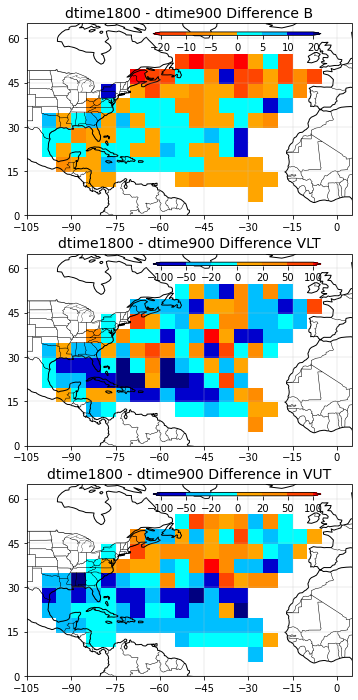

In [71]:
Fig = Spatial_Diff_Plot("dtime1800", "dtime900", Dtime1800_Spatial_B, Dtime900_Spatial_B, \
Dtime1800_Spatial_VLT, Dtime900_Spatial_VLT, Dtime1800_Spatial_VUT, Dtime900_Spatial_VUT, \
Lon_Bins, Lat_Bins, Diff_Bounds, Diff_Colours)

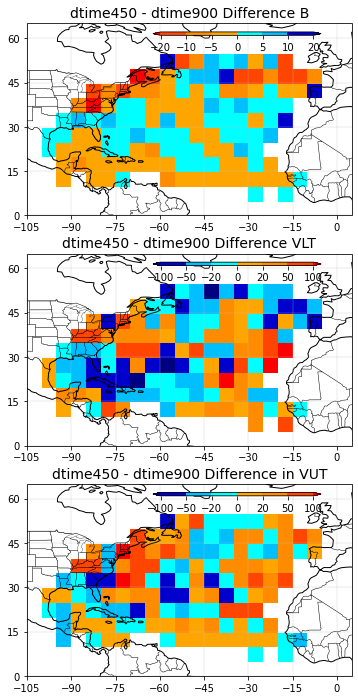

In [72]:
Fig = Spatial_Diff_Plot("dtime450", "dtime900", Dtime450_Spatial_B, Dtime900_Spatial_B, \
Dtime450_Spatial_VLT, Dtime900_Spatial_VLT, Dtime450_Spatial_VUT, Dtime900_Spatial_VUT, \
Lon_Bins, Lat_Bins, Diff_Bounds, Diff_Colours)

In [73]:
# Number of Years in Dataset
Dtime1800_Years = 22
Dtime900_Years = 30
Dtime450_Years = 22
#
# Bins For Different Variables
SLP_Bins = numpy.arange(870,1020,10)
Winds_Bins = numpy.arange(10,110,10)
Lon_Hist_Bins = numpy.arange(-100,10,10)
Lat_Hist_Bins = numpy.arange(0,70,10)
print (Winds_Bins)

[ 10  20  30  40  50  60  70  80  90 100]


In [74]:
# Create Function to Make Storm SLP Distribution
def Storm_Var_Dist(DF, Years, Bins, Var):
# Find Total Number of Points
    if Var == "SLP(hPa)":
        Count = numpy.zeros(len(Bins))
        for l in range(len(Count)):
            if l == 0:
                DF_Range = DF[DF[Var] <= Bins[l]]
            else:
                DF_Range = DF[(DF[Var] > Bins[l-1]) & (DF[Var] <= Bins[l])]
            Count[l] = len(DF_Range[Var])
    elif Var == "Winds(m/s)" or Var == "Lat":
        Count = numpy.zeros(len(Bins))
        for l in range(len(Count)):
            if l == len(Count)-1:
                DF_Range = DF[DF[Var] >= Bins[l]]
            else:
                DF_Range = DF[(DF[Var] < Bins[l+1]) & (DF[Var] >= Bins[l])]
            Count[l] = len(DF_Range[Var])
    else:
        Count = numpy.zeros(len(Bins)+1)
        for l in range(len(Count)):
            if l == 0:
                DF_Range = DF[DF[Var] < Bins[l]]
            elif l == len(Count)-1:
                DF_Range = DF[DF[Var] >= Bins[l]]
            else:
                DF_Range = DF[(DF[Var] < Bins[l+1]) & (DF[Var] >= Bins[l])]
    Density = Count / Years
    return (Density)

In [75]:
SLP_Dist_Array = numpy.zeros((3,len(SLP_Bins)))
SLP_Dist_Array[0] = Storm_Var_Dist(Dtime450_DF, Dtime450_Years, SLP_Bins, "SLP(hPa)")
SLP_Dist_Array[1] = Storm_Var_Dist(Dtime900_DF, Dtime900_Years, SLP_Bins, "SLP(hPa)")
SLP_Dist_Array[2] = Storm_Var_Dist(Dtime1800_DF, Dtime1800_Years, SLP_Bins, "SLP(hPa)")

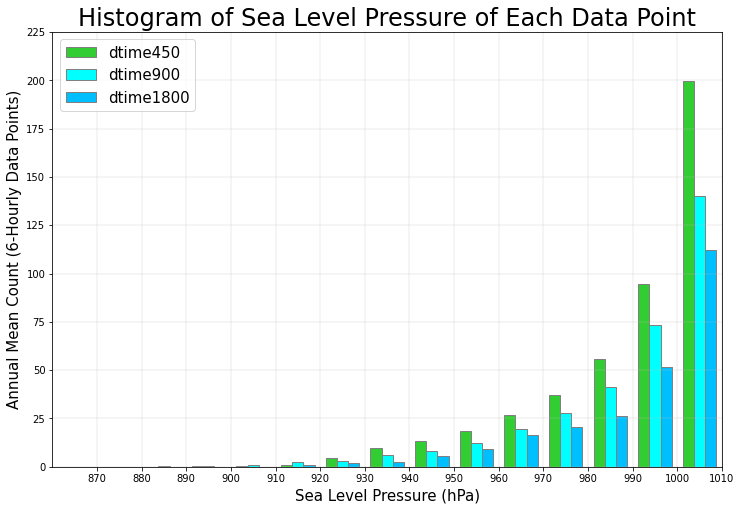

In [76]:
# Create Histogram Comparing Storm Pressure Distribution
Fig = pyplot.figure(figsize=(12,8))
Axis = Fig.add_subplot(1,1,1)
#
# Create Bars
Bar_Width = 0.25
Bar1 = numpy.arange(len(SLP_Dist_Array[0]))
Bar2 = [x + Bar_Width for x in Bar1]
Bar3 = [x + Bar_Width for x in Bar2]
Bars = [Bar1, Bar2, Bar3]
Colours = ['limegreen', 'aqua', 'deepskyblue']
Models = ['dtime450', 'dtime900', 'dtime1800']
#
# Plot Histogram
for l in range(3):
    Axis.bar(Bars[l], SLP_Dist_Array[l], width=Bar_Width, color=Colours[l], edgecolor='grey', label=Models[l])
#
# Formatting
pyplot.xticks([n+1-Bar_Width for n in range(len(SLP_Bins))], SLP_Bins)
pyplot.yticks(numpy.arange(0,250,25))
pyplot.xlim(-0.25,len(SLP_Bins)-0.25)
pyplot.ylim(0,225)
Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
pyplot.legend(loc=2, fontsize=15)
pyplot.xlabel('Sea Level Pressure (hPa)', fontsize=15)
pyplot.ylabel('Annual Mean Count (6-Hourly Data Points)', fontsize=15)
pyplot.title('Histogram of Sea Level Pressure of Each Data Point', fontsize=24)
pyplot.show()

In [77]:
Winds_Dist_Array = numpy.zeros((3,len(Winds_Bins)))
Winds_Dist_Array[0] = Storm_Var_Dist(Dtime450_DF, Dtime450_Years, Winds_Bins, "Winds(m/s)")
Winds_Dist_Array[1] = Storm_Var_Dist(Dtime900_DF, Dtime900_Years, Winds_Bins, "Winds(m/s)")
Winds_Dist_Array[2] = Storm_Var_Dist(Dtime1800_DF, Dtime1800_Years, Winds_Bins, "Winds(m/s)")
Winds_Dist_Array

array([[1.51045455e+02, 2.23227273e+02, 8.47727273e+01, 4.16363636e+01,
        2.31363636e+01, 1.33181818e+01, 3.22727273e+00, 4.09090909e-01,
        0.00000000e+00, 0.00000000e+00],
       [1.05266667e+02, 1.48900000e+02, 6.24333333e+01, 2.77333333e+01,
        1.69666667e+01, 9.63333333e+00, 4.10000000e+00, 1.36666667e+00,
        5.00000000e-01, 3.33333333e-02],
       [1.04272727e+02, 1.16000000e+02, 4.09090909e+01, 1.69090909e+01,
        1.21818182e+01, 5.00000000e+00, 9.54545455e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]])

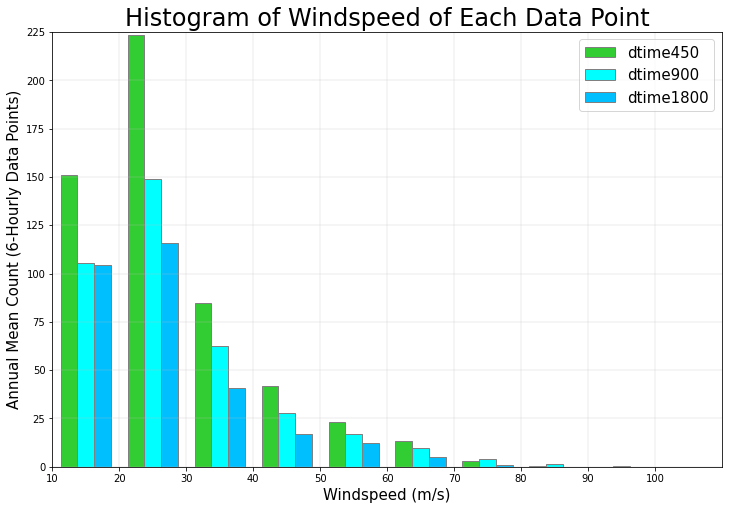

In [78]:
# Create Histogram Comparing Storm Pressure Distribution
Fig = pyplot.figure(figsize=(12,8))
Axis = Fig.add_subplot(1,1,1)
#
# Create Bars
Bar_Width = 0.25
Bar1 = numpy.arange(len(Winds_Dist_Array[0]))
Bar2 = [x + Bar_Width for x in Bar1]
Bar3 = [x + Bar_Width for x in Bar2]
Bars = [Bar1, Bar2, Bar3]
Colours = ['limegreen', 'aqua', 'deepskyblue']
Models = ['dtime450', 'dtime900', 'dtime1800']
#
# Plot Histogram
for l in range(3):
    Axis.bar(Bars[l], Winds_Dist_Array[l], width=Bar_Width, color=Colours[l], edgecolor='grey', label=Models[l])
#
# Formatting
pyplot.xticks([n-Bar_Width for n in range(len(Winds_Bins))], Winds_Bins)
pyplot.yticks(numpy.arange(0,250,25))
pyplot.xlim(-0.25,len(Winds_Bins)-0.25)
pyplot.ylim(0,225)
Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
pyplot.legend(loc=1, fontsize=15)
pyplot.xlabel('Windspeed (m/s)', fontsize=15)
pyplot.ylabel('Annual Mean Count (6-Hourly Data Points)', fontsize=15)
pyplot.title('Histogram of Windspeed of Each Data Point', fontsize=24)
pyplot.show()

In [79]:
Lon_Dist_Array = numpy.zeros((3,len(Lon_Bins)+1))
Lon_Dist_Array[0] = Storm_Var_Dist(Dtime450_DF, Dtime450_Years, Lon_Bins, "Lon")
Lon_Dist_Array[1] = Storm_Var_Dist(Dtime900_DF, Dtime900_Years, Lon_Bins, "Lon")
Lon_Dist_Array[2] = Storm_Var_Dist(Dtime1800_DF, Dtime1800_Years, Lon_Bins, "Lon")
Lon_Dist_Array

IndexError: index 25 is out of bounds for axis 0 with size 25

In [ ]:
Dtime900_DF

In [ ]:
# Create List Containing Each Model Data For Making Box Plots
SLP_Box = [numpy.array(Dtime450_DF["SLP(hPa)"]), numpy.array(Dtime900_DF["SLP(hPa)"]), numpy.array(Dtime1800_DF["SLP(hPa)"])]
Winds_Box = [numpy.array(Dtime450_DF["Winds(m/s)"]), numpy.array(Dtime900_DF["Winds(m/s)"]), numpy.array(Dtime1800_DF["Winds(m/s)"])]
#
# Formatting
Colours = ['limegreen', 'turquoise', 'deepskyblue']
Models = ['dtime450', 'dtime900', 'dtime1800']
def Formatting(Boxplot, Axis, Colours, Models):
    Axis.set_yticklabels(Models, fontsize=10)
    Axis.set_ylabel('Model', fontsize=12)
    for Patch, Colour in zip(Boxplot['boxes'], Colours): 
        Patch.set_facecolor(Colour)
    for Median in Boxplot['medians']: 
        Median.set(color='black', linewidth=1.8)
    for Flier in Boxplot['fliers']:
        Flier.set(marker='x', markersize=3.8, alpha=0.3)

In [ ]:
# Plot Box Plots
Fig = pyplot.figure(figsize=(8,10))
#
# Sea Level Pressure
Axis = Fig.add_subplot(2,1,1)
SLP_Boxplot = pyplot.boxplot(SLP_Box, patch_artist=True, vert=0)
Formatting(SLP_Boxplot, Axis, Colours, Models)
Axis.set_xlabel('SLP (hPa)', fontsize=12)
Axis.set_xlim(860,1030)
Axis.set_xticks(numpy.arange(860,1040,10))
Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
#
# Windspeed
Axis = Fig.add_subplot(2,1,2)
Winds_Boxplot = pyplot.boxplot(Winds_Box, patch_artist=True, vert=0)
Formatting(Winds_Boxplot, Axis, Colours, Models)
Axis.set_xlabel('Windspeed (m/s)', fontsize=12)
Axis.set_xlim(0,110)
Axis.set_xticks(numpy.arange(0,120,10))
Gridline = Axis.grid(linewidth=0.3, color='silver', linestyle='-')
#
# Output Fig
pyplot.tight_layout()
#Fig.savefig('Q2b.png', bbox_inches='tight')